## Validation - Synthetic Data
- [Case 1: 1 Observation 2 Parameters](#Case-1%3A-1-Observation-2-Parameters)
- [Case 2: 1 Observation 3 Parameters](#Case-2%3A-1-Observation-3-Parameters)
- [Case 3: 25 Observations 3 Parameters](#Case-3%3A-25-Observations-3-Parameters)

In this notebook, we create a synthetic asteroid using `ATM`'s implementation of NEATM and simulate a single observation. We fit for logD and logT1 (Case 1), and then fit for logD, logT1 and eps_W1W2  (Case 2). For Case 1, we recover the input parameters, but we show that for Case 2 we cannot as we are subject to fitting degeneracies. We then repeat Case 2 but this time model 25 observations and reduce $\Sigma$ from 0.2 mag to 0.1 mag and show that with an adequate number of observations we can overcome those degeneracies (Case 3).

This notebook creates Figures 1-4 in the ATM paper.

In [1]:
import os 
import sys
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("../..")

from atm.models import STM, FRM, NEATM
from atm.obs import WISE
from atm import fit
from atm import modifyErrors

# Additonal imports to make simulated data
from atm import Config
from atm.functions import calcTss, calcQ
from atm.functions import interpFluxLambdaObsWithSunlight
from atm.functions import calcFluxLambdaObsWithSunlight
from atm.functions import calcFluxLambdaAtObsWithSunlight
from atm.functions import calcFluxLambdaSED
from atm.plotting import plotObservations, plotSED

%matplotlib inline

In [2]:
DPI = 600
SAVE_DIR = "../plots/"
FORMAT = "png"

SAVE_FIGS = True

In [3]:
m_to_mum = 1e6 # simple conversion from m to micron
km_to_m = 1e3 # conversion km to m

### Case 1: 1 Observation

In [4]:
# Instantiate observatory and NEATM class for simulating data
obs = WISE()
model = NEATM(verbose=False)

In [5]:
# Load WISE quadrature lookup tables into memory 
model.loadLambdaTables(obs.filterQuadratureLambdas, verbose=False)

In [6]:
# Create observing geometry
num_obs = 1
r = np.random.normal(loc=3.5, scale=0.01, size=num_obs)
delta = r - 1.0
alpha = np.zeros(num_obs)

In [7]:
# Fractional flux error of 0.1% (will add 0.2 mag Sigma later)
err = 0.001

In [8]:
# Create fake asteroid
# Here we set a value of T1, we could also explicitly calculate T_ss 
#   using atm.functions.calcTss and from there calculate T1, however this is not needed 
#   for this example
G = 0.15 * np.ones(num_obs)
D = 1000 * np.ones(num_obs)
logD = np.log10(D) * np.ones(num_obs)
eps = np.array(0.70) * np.ones(num_obs)
p = (1 - eps) / calcQ(G)
T1 = 422. * np.ones(num_obs)
logT1 = np.log10(T1)
T_ss = T1 / np.sqrt(r)

In [9]:
# Model flux with sunlight
flux = interpFluxLambdaObsWithSunlight(model, obs, r, delta, T_ss, D, alpha, eps, p, G).T
fluxErr = err * flux
mag = obs.convertFluxLambdaToMag(flux)
magErr = obs.convertFluxLambdaErrToMagErr(flux, fluxErr)

data = np.vstack([r, delta, alpha, G, D, logD, T1, logT1, T_ss,
                  flux[:, 0], flux[:, 1], flux[:, 2], flux[:, 3],
                  fluxErr[:, 0], fluxErr[:, 1], fluxErr[:, 2], fluxErr[:, 3],
                  mag[:, 0], mag[:, 1], mag[:, 2], mag[:, 3],
                  magErr[:, 0], magErr[:, 1], magErr[:, 2], magErr[:, 3]])

data = pd.DataFrame(data.T, columns=["r",
                                     "delta",
                                     "alpha",
                                     "G",
                                     "D",
                                     "logD",
                                     "T1",
                                     "logT1",
                                     "T_ss",
                                     "flux_W1_si",
                                     "flux_W2_si",
                                     "flux_W3_si",
                                     "flux_W4_si",
                                     "fluxErr_W1_si",
                                     "fluxErr_W2_si",
                                     "fluxErr_W3_si",
                                     "fluxErr_W4_si",
                                     "mag_W1",
                                     "mag_W2",
                                     "mag_W3",
                                     "mag_W4",
                                     "magErr_W1",
                                     "magErr_W2",
                                     "magErr_W3",
                                     "magErr_W4"])
data["obs_id"] = np.arange(1, len(data) + 1)
data["eps"] = eps 
data["p"] = p
data["designation"] = ["0000" for i in range(len(data))]
data = data[["obs_id", "designation", "r", "delta", "alpha", "G", "D", "logD", "T1", "logT1", "T_ss", "eps", "p",
             "flux_W1_si", "flux_W2_si", "flux_W3_si", "flux_W4_si", 
             "fluxErr_W1_si", "fluxErr_W2_si", "fluxErr_W3_si", "fluxErr_W4_si",
             "mag_W1", "mag_W2", "mag_W3", "mag_W4",
             "magErr_W1", "magErr_W2", "magErr_W3", "magErr_W4"]]

In [10]:
columnMapping = {
    "designation" : "designation",
    "obs_id" : "obs_id",
    "r_au" : "r",
    "delta_au" : "delta",
    "alpha_rad" : "alpha",
    "G" : "G",
    "logT1" : "logT1",
    "logD": "logD",
    "eps" : "eps", 
    "flux_si": ["flux_W1_si", "flux_W2_si", "flux_W3_si", "flux_W4_si"],
    "fluxErr_si": ["fluxErr_W1_si", "fluxErr_W2_si", "fluxErr_W3_si", "fluxErr_W4_si"],
    "mag" : ["mag_W1", "mag_W2", "mag_W3", "mag_W4"],
    "magErr" : ["magErr_W1", "magErr_W2", "magErr_W3", "magErr_W4"]
}
fitParameters = ["logT1", "logD"]
fitFilters = "all"
emissivitySpecification = None
albedoSpecification = "auto"

# Wavelength config for calculating SEDs
lambdaRange=[1e-6, 30e-6]
lambdaNum=250
lambdaEdges=[3.9e-6, 6.5e-6, 18.5e-6]
linearInterpolation=False

In [11]:
# Modify errors: add sigma of 0.2 mag to account for rotation
data = modifyErrors(data, obs, sigma=0.2, columnMapping=columnMapping)

Added 0.2 magnitude errors to magErr_W1.
Added 0.2 magnitude errors to magErr_W2.
Added 0.2 magnitude errors to magErr_W3.
Added 0.2 magnitude errors to magErr_W4.
Converted magnitude errors to flux errors.
Updating fluxErr_W1_si with new error.
Updating fluxErr_W2_si with new error.
Updating fluxErr_W3_si with new error.
Updating fluxErr_W4_si with new error.
Done.



In [12]:
data

obs_id designation         r     delta  alpha     G       D  logD     T1  \
0       1        0000  3.511293  2.511293    0.0  0.15  1000.0   3.0  422.0   

      logT1  ...  fluxErr_W3_si  fluxErr_W4_si     mag_W1     mag_W2  \
0  2.625312  ...   9.337336e-13   6.738194e-13  19.006169  18.811278   

      mag_W3     mag_W4  magErr_W1  magErr_W2  magErr_W3  magErr_W4  
0  12.766173  10.309917   0.201086   0.201086   0.201086   0.201086  

[1 rows x 29 columns]

In [13]:
# Generate truth at a variety of wavelengths for plotting
model = NEATM(verbose=False)

SED_neatm = calcFluxLambdaSED(model, obs, data,
                              emissivitySpecification=emissivitySpecification,
                              albedoSpecification=albedoSpecification,
                              columnMapping=columnMapping,
                              lambdaRange=lambdaRange,
                              lambdaNum=lambdaNum,
                              lambdaEdges=lambdaEdges,
                              linearInterpolation=linearInterpolation)   

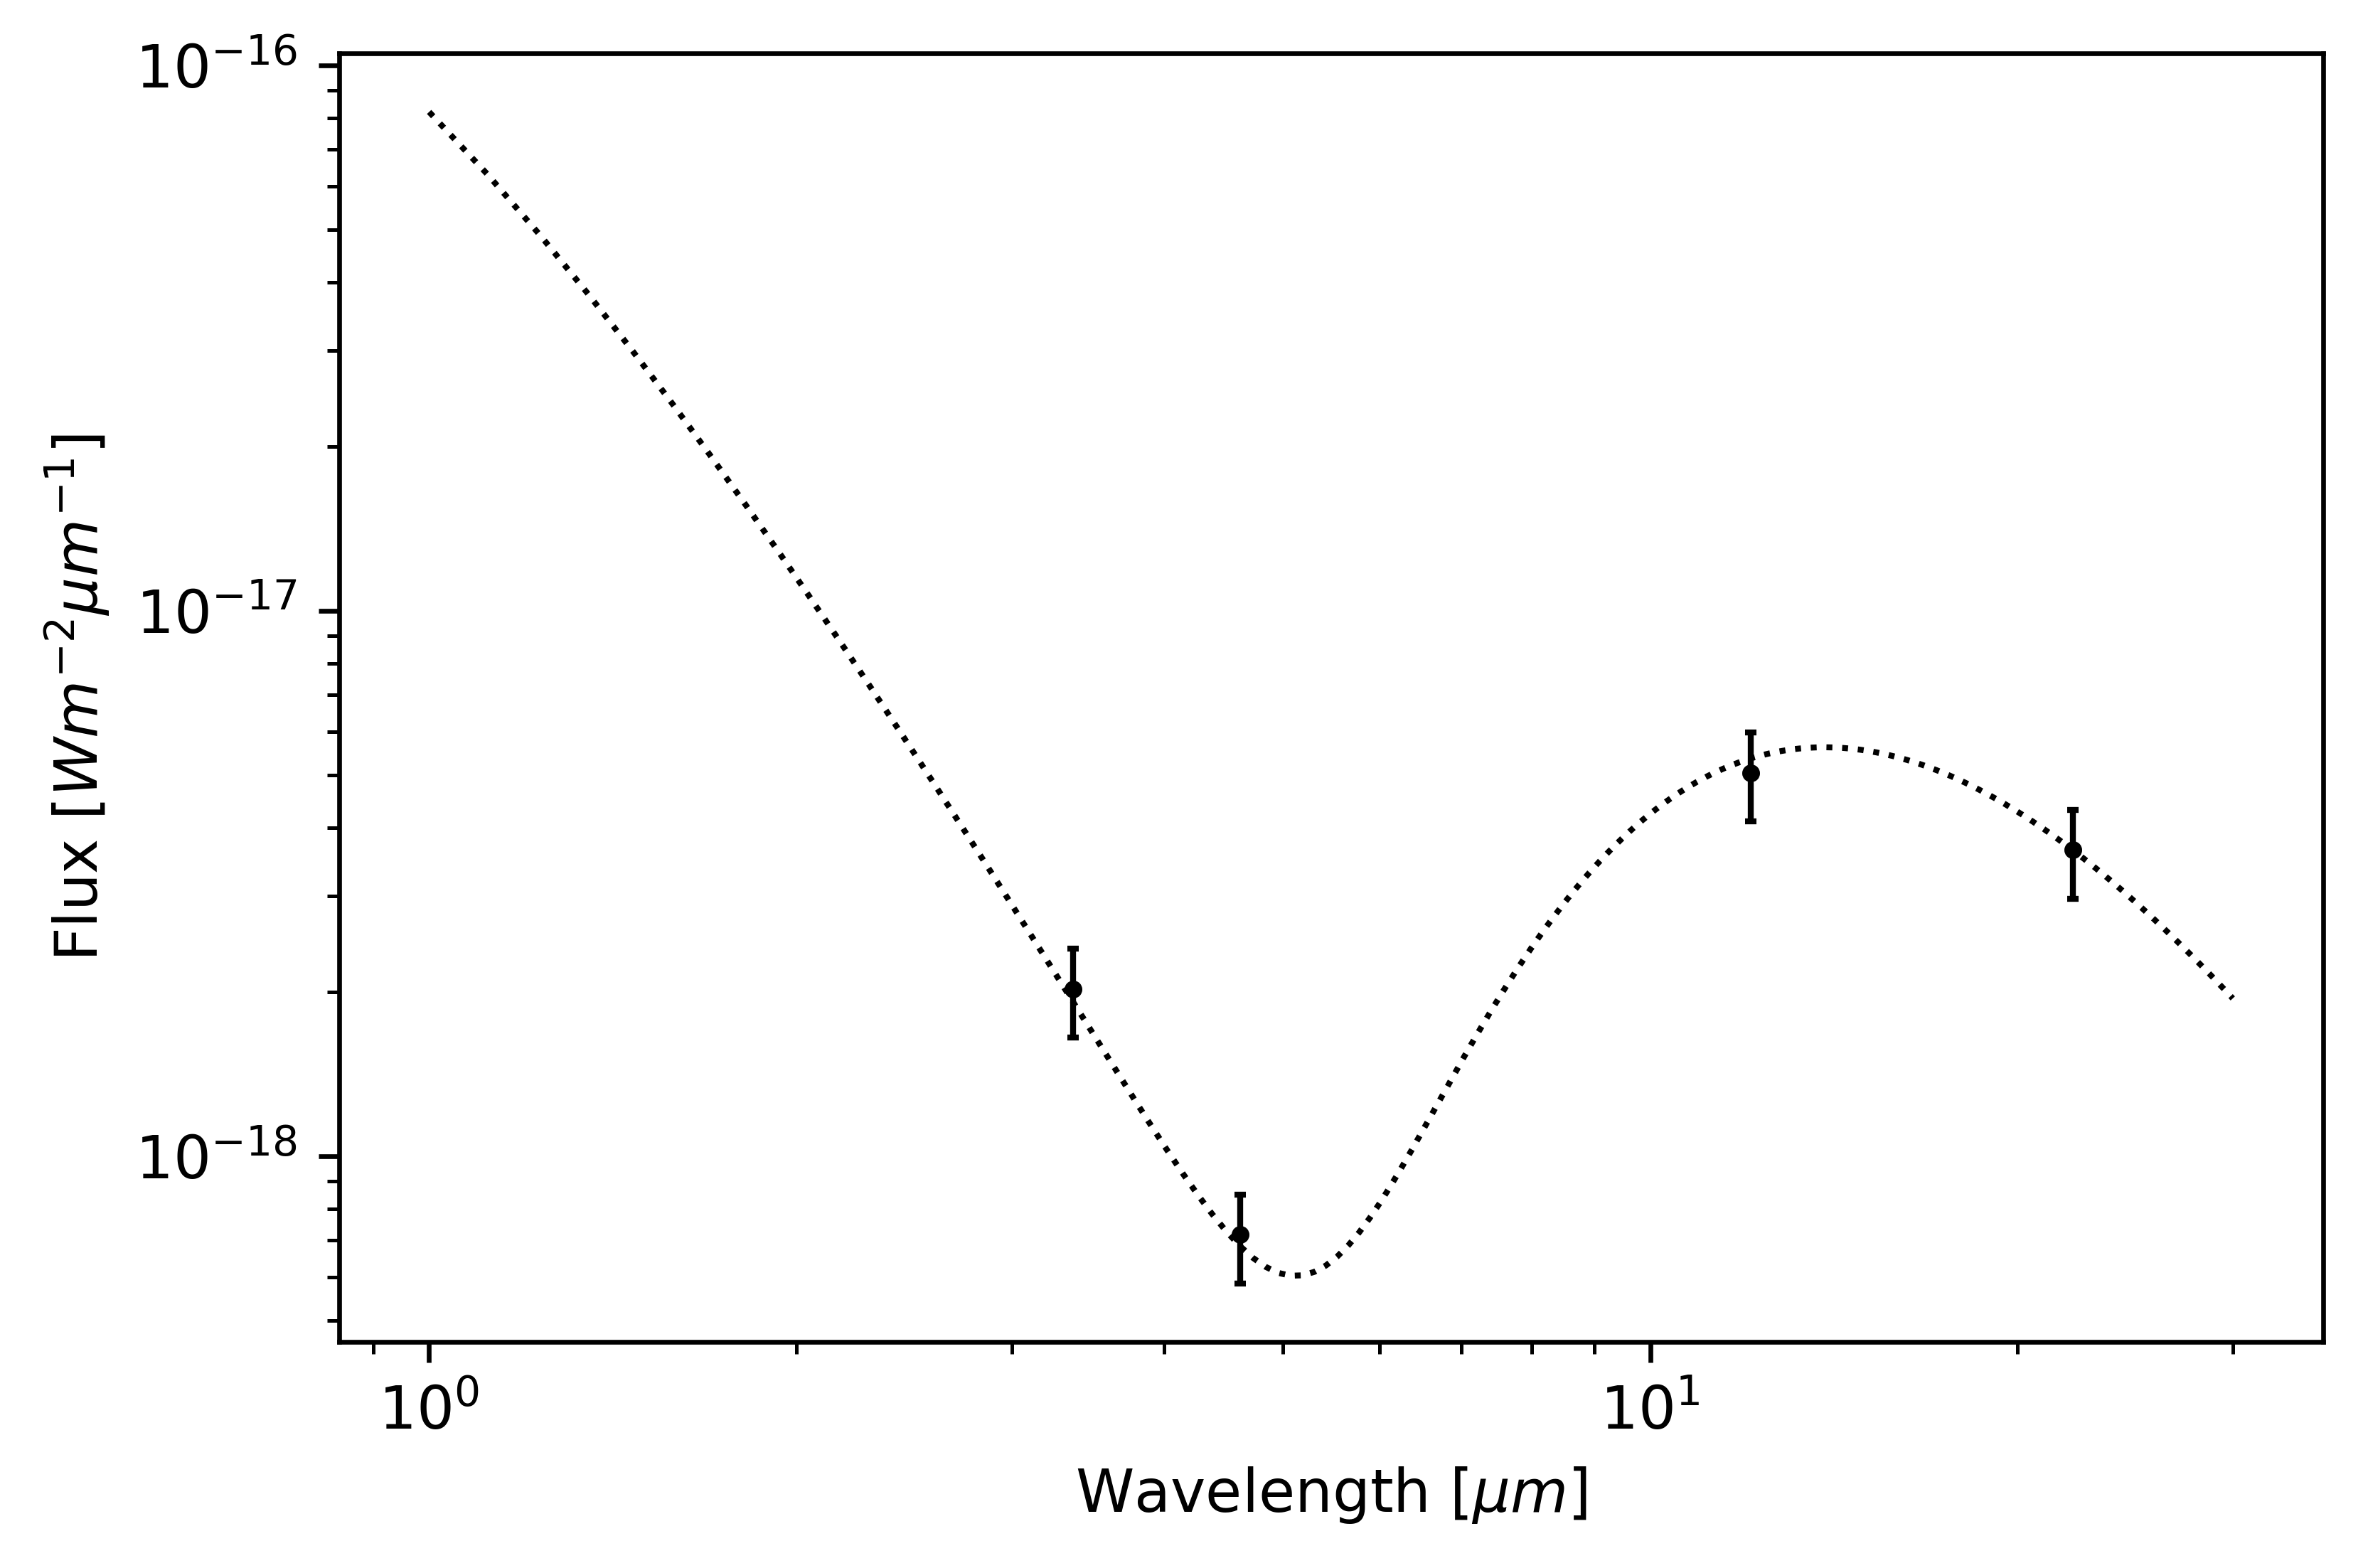

In [14]:
fig, ax = plt.subplots(1, 1, dpi=DPI)
plotSED(SED_neatm, ax=ax)
plotObservations(obs, data, 
                 ax=ax, 
                 plotMedian=True, 
                 columnMapping=columnMapping)

Fitting 0000 with STM...
Fit Code: 1
Fit Parameters: ['logT1', 'logD']
Emissivity Parameters: ['eps']
Emissivity Specification: None
Albedo Parameters: ['p']
Albedo Specification: auto
Number of observations: 1
Ignoring data parameters: ['logT1', 'logD']
Chains: 10
Samples per Chain: 3000
Burn-in Samples: 500
Effective Samples per Chain: 2500
Threads: 10


Multiprocess sampling (10 chains in 10 jobs)
CompoundStep
>Metropolis: [logT1]
>Metropolis: [logD]
The number of effective samples is smaller than 10% for some parameters.


Found best fit parameters:
 logT1: 2.629 +- 0.021
 logD:  2.991 +- 0.036
Total time: 27.36 seconds
Done.



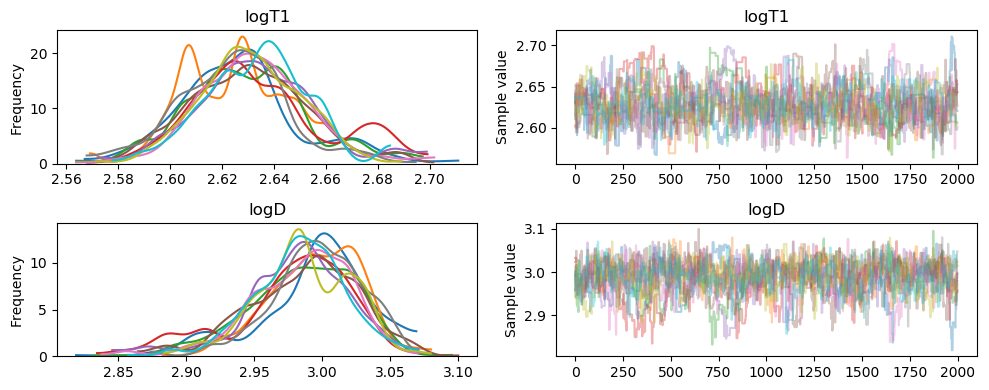

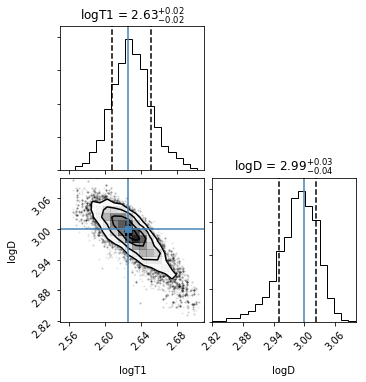

In [15]:
# Run STM
model = STM(verbose=False)
summary_stm, model_observations_stm, pymc_objs_stm = fit(
    model, 
    obs, 
    data,
    fitParameters=fitParameters, 
    fitFilters=fitFilters,
    emissivitySpecification=emissivitySpecification, 
    albedoSpecification=albedoSpecification,
    columnMapping=columnMapping,
    verbose=False)

Fitting 0000 with FRM...
Fit Code: 1
Fit Parameters: ['logT1', 'logD']
Emissivity Parameters: ['eps']
Emissivity Specification: None
Albedo Parameters: ['p']
Albedo Specification: auto
Number of observations: 1
Ignoring data parameters: ['logT1', 'logD']
Chains: 10
Samples per Chain: 3000
Burn-in Samples: 500
Effective Samples per Chain: 2500
Threads: 10


Multiprocess sampling (10 chains in 10 jobs)
CompoundStep
>Metropolis: [logT1]
>Metropolis: [logD]
The number of effective samples is smaller than 10% for some parameters.


Found best fit parameters:
 logT1: 2.599 +- 0.020
 logD:  2.997 +- 0.035
Total time: 22.26 seconds
Done.



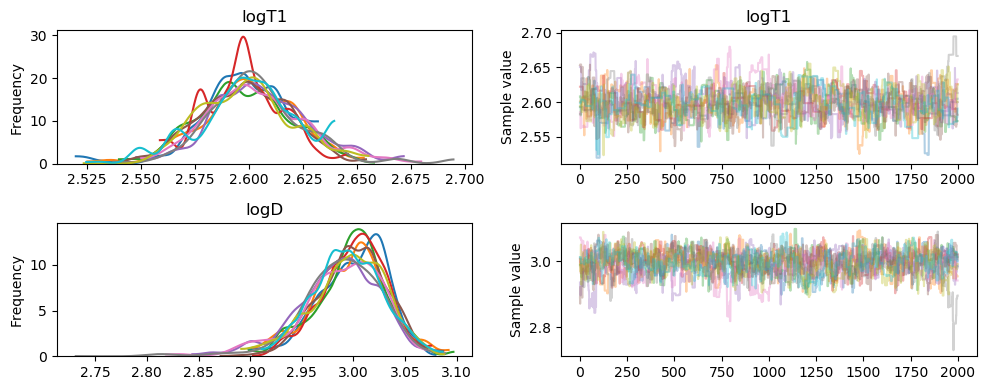

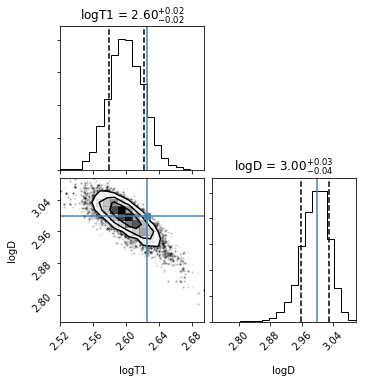

In [16]:
# Run FRM
model = FRM(verbose=False)
summary_frm, model_observations_frm, pymc_objs_frm = fit(
    model, 
    obs, 
    data, 
    fitParameters=fitParameters, 
    emissivitySpecification=emissivitySpecification, 
    albedoSpecification=albedoSpecification,
    columnMapping=columnMapping,
    verbose=False)

Fitting 0000 with NEATM...
Fit Code: 1
Fit Parameters: ['logT1', 'logD']
Emissivity Parameters: ['eps']
Emissivity Specification: None
Albedo Parameters: ['p']
Albedo Specification: auto
Number of observations: 1
Ignoring data parameters: ['logT1', 'logD']
Chains: 10
Samples per Chain: 3000
Burn-in Samples: 500
Effective Samples per Chain: 2500
Threads: 10


Multiprocess sampling (10 chains in 10 jobs)
CompoundStep
>Metropolis: [logT1]
>Metropolis: [logD]
The number of effective samples is smaller than 10% for some parameters.


Found best fit parameters:
 logT1: 2.627 +- 0.021
 logD:  2.994 +- 0.036
Total time: 21.52 seconds
Done.



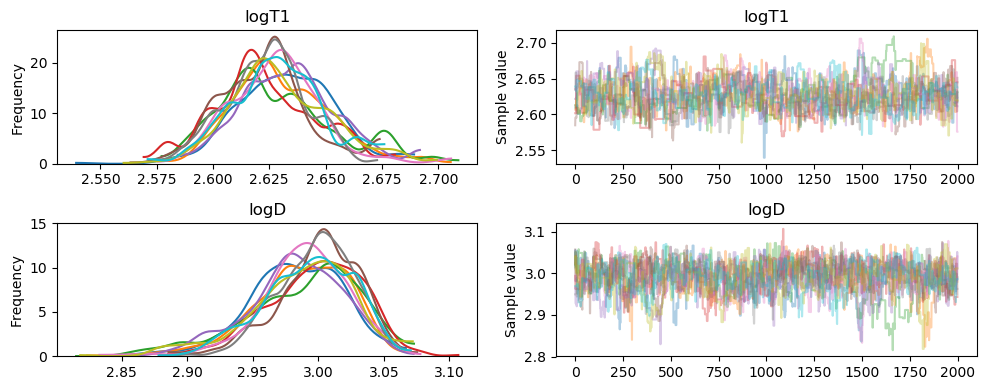

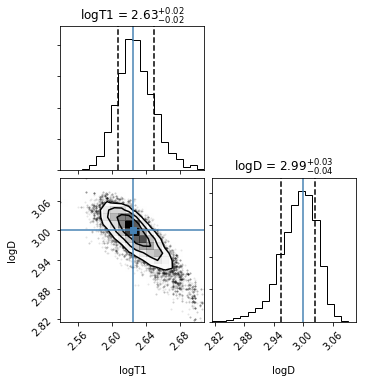

In [17]:
# Run NEATM
model = NEATM(verbose=False)
summary_neatm, model_observations_neatm, pymc_objs_neatm, figs = fit(
    model, 
    obs, 
    data, 
    fitParameters=fitParameters, 
    emissivitySpecification=emissivitySpecification,
    albedoSpecification=albedoSpecification,
    columnMapping=columnMapping,
    returnFigs=True,
    verbose=False)
if SAVE_FIGS is True:
    fig_corner = figs[1]
    fig_corner.savefig(os.path.join(SAVE_DIR, "validation_synthetic_1obs_2param_NEATM_corner".format(FORMAT)), 
                       bbox_inches='tight',
                       dpi=DPI)

In [18]:
# Truth parameters
data[fitParameters]

logT1  logD
0  2.625312   3.0

In [19]:
# Fitting results
summary_stm

designation model  code parameter    median    sigmaG      mean        sd  \
0        0000   STM     1     logT1  2.628884  0.020935  2.629824  0.022224   
1        0000   STM     1      logD  2.990556  0.035967  2.986580  0.037929   

   mc_error       n_eff      Rhat   hpd_2.5  hpd_97.5  
0  0.001051  397.927062  1.016784  2.587153  2.676887  
1  0.001759  385.037901  1.018149  2.907546  3.056023

In [20]:
# Fitting results
summary_frm

designation model  code parameter    median    sigmaG      mean        sd  \
0        0000   FRM     1     logT1  2.598966  0.019987  2.599836  0.021444   
1        0000   FRM     1      logD  2.996992  0.034651  2.994071  0.035535   

   mc_error       n_eff      Rhat   hpd_2.5  hpd_97.5  
0  0.000975  537.659651  1.011950  2.558824  2.639893  
1  0.001566  510.255373  1.016274  2.922262  3.058426

In [21]:
# Fitting results
summary_neatm

designation  model  code parameter    median    sigmaG      mean        sd  \
0        0000  NEATM     1     logT1  2.626922  0.020828  2.627839  0.021445   
1        0000  NEATM     1      logD  2.994141  0.035865  2.990061  0.036341   

   mc_error       n_eff      Rhat   hpd_2.5  hpd_97.5  
0  0.001065  295.130239  1.018237  2.587691  2.672886  
1  0.001765  323.841833  1.015893  2.916612  3.056233

In [22]:
# Use best-fit parameters to model fluxes
model = STM(verbose=False)

SED_stm_fit = calcFluxLambdaSED(model, obs, data,
                                summary=summary_stm,
                                fitParameters=fitParameters,
                                emissivitySpecification=emissivitySpecification,
                                albedoSpecification=albedoSpecification,
                                columnMapping=columnMapping,
                                lambdaRange=lambdaRange,
                                lambdaNum=lambdaNum,
                                lambdaEdges=lambdaEdges,
                                linearInterpolation=linearInterpolation)   

# Use best-fit parameters to model fluxes
model = FRM(verbose=False)

SED_frm_fit = calcFluxLambdaSED(model, obs, data,
                                summary=summary_frm,
                                fitParameters=fitParameters,
                                emissivitySpecification=emissivitySpecification,
                                albedoSpecification=albedoSpecification,
                                columnMapping=columnMapping,
                                lambdaRange=lambdaRange,
                                lambdaNum=lambdaNum,
                                lambdaEdges=lambdaEdges,
                                linearInterpolation=linearInterpolation)       

# Use best-fit parameters to model fluxes
model = NEATM(verbose=False)

SED_neatm_fit = calcFluxLambdaSED(model, obs, data,
                                  summary=summary_neatm,
                                  fitParameters=fitParameters,
                                  emissivitySpecification=emissivitySpecification,
                                  albedoSpecification=albedoSpecification,
                                  columnMapping=columnMapping,
                                  lambdaRange=lambdaRange,
                                  lambdaNum=lambdaNum,
                                  lambdaEdges=lambdaEdges,
                                  linearInterpolation=linearInterpolation)       


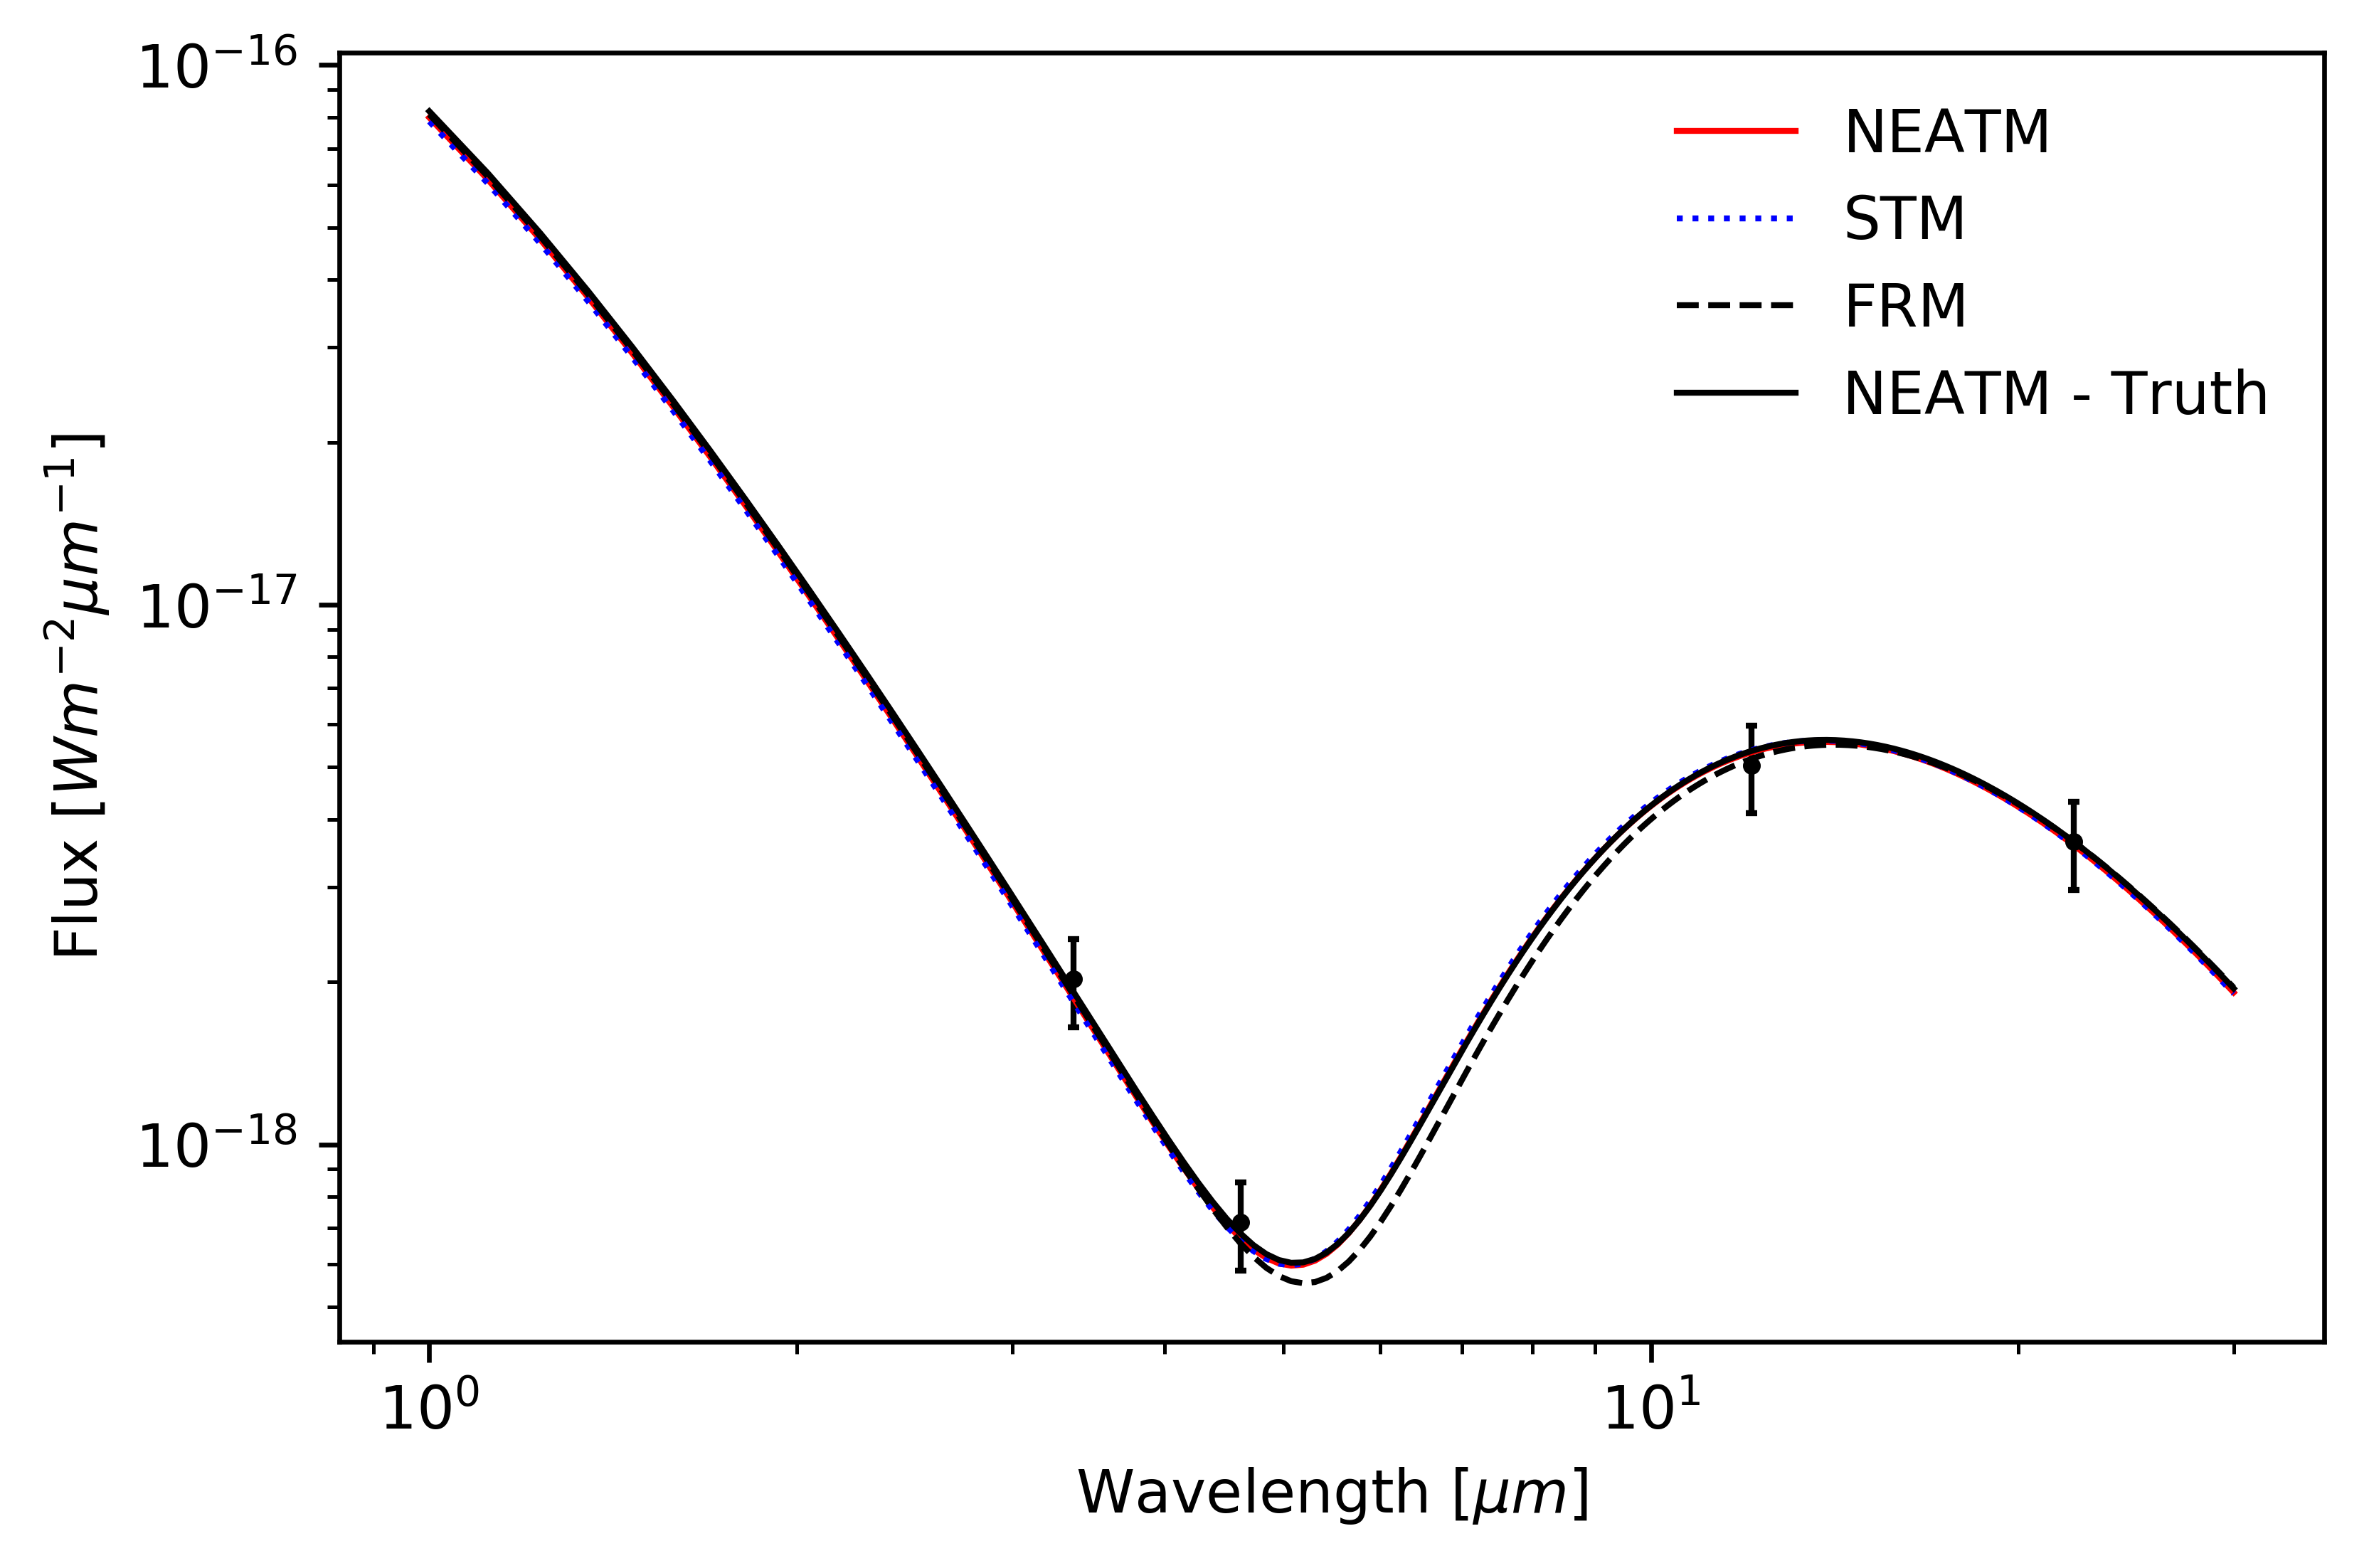

In [23]:
fig, ax = plt.subplots(1, 1, dpi=DPI)
plotSED(SED_neatm_fit, 
        ax=ax, 
        plotKwargs={"label": "NEATM", 
                    "c": "r", 
                    "lw": 1})
plotSED(SED_stm_fit, 
        ax=ax, 
        plotKwargs={"label": "STM", 
                    "c": "b", 
                    "ls": ":", 
                    "lw": 1})
plotSED(SED_frm_fit, 
        ax=ax, 
        plotKwargs={"label": "FRM", 
                    "c": "k", 
                    "ls": "--", 
                    "lw": 1})
plotSED(SED_neatm, 
        ax=ax, 
        plotKwargs={"label":"NEATM - Truth", 
                    "c" : "k" , 
                    "lw": 1})
plotObservations(obs, data, 
                 ax=ax, 
                 plotMedian=True, 
                 columnMapping=columnMapping)
ax.legend(frameon=False)
if SAVE_FIGS is True:
    fig.savefig(os.path.join(SAVE_DIR, "validation_synthetic_1obs_2param_SEDs".format(FORMAT)), 
                bbox_inches='tight',
                dpi=DPI)

### Case 2: 1 Observation 3 Parameters

In [24]:
# Instantiate observatory and NEATM class for simulating data
obs = WISE()
model = NEATM(verbose=False)

In [25]:
# Load WISE quadrature lookup tables into memory 
model.loadLambdaTables(obs.filterQuadratureLambdas, verbose=False)

In [26]:
# Create observing geometry
num_obs = 1
r = np.random.normal(loc=3.0, scale=0.01, size=num_obs)
delta = r - 1.0
alpha = np.zeros(num_obs)

In [27]:
# Fractional flux error of 0.1% (will add 0.2 mag Sigma later)
err = 0.001

In [28]:
# Create fake asteroid
# Here we set a value of T1, we could also explicitly calculate T_ss 
#   using atm.functions.calcTss and from there calculate T1, however this is not needed 
#   for this example
G = 0.15 * np.ones(num_obs)
D = 1000 * np.ones(num_obs)
logD = np.log10(D) * np.ones(num_obs)
eps_W3W4 = np.array(0.70) * np.ones(num_obs)
eps_W1W2 = np.array(0.70) * np.ones(num_obs)
p_W1W2 = (1 - eps_W1W2) / calcQ(G)
p_W3W4 = (1 - eps_W3W4) / calcQ(G)
T1 = 422. * np.ones(num_obs)
logT1 = np.log10(T1)
T_ss = T1 / np.sqrt(r)

In [29]:
# Model flux with sunlight
flux = interpFluxLambdaObsWithSunlight(model, obs, r, delta, T_ss, D, alpha, eps, p, G).T
fluxErr = err * flux
mag = obs.convertFluxLambdaToMag(flux)
magErr = obs.convertFluxLambdaErrToMagErr(flux, fluxErr)

data = np.vstack([r, delta, alpha, G, D, logD, T1, logT1, T_ss,
                  flux[:, 0], flux[:, 1], flux[:, 2], flux[:, 3],
                  fluxErr[:, 0], fluxErr[:, 1], fluxErr[:, 2], fluxErr[:, 3],
                  mag[:, 0], mag[:, 1], mag[:, 2], mag[:, 3],
                  magErr[:, 0], magErr[:, 1], magErr[:, 2], magErr[:, 3]])

data = pd.DataFrame(data.T, columns=["r",
                                     "delta",
                                     "alpha",
                                     "G",
                                     "D",
                                     "logD",
                                     "T1",
                                     "logT1",
                                     "T_ss",
                                     "flux_W1_si",
                                     "flux_W2_si",
                                     "flux_W3_si",
                                     "flux_W4_si",
                                     "fluxErr_W1_si",
                                     "fluxErr_W2_si",
                                     "fluxErr_W3_si",
                                     "fluxErr_W4_si",
                                     "mag_W1",
                                     "mag_W2",
                                     "mag_W3",
                                     "mag_W4",
                                     "magErr_W1",
                                     "magErr_W2",
                                     "magErr_W3",
                                     "magErr_W4"])
data["obs_id"] = np.arange(1, len(data) + 1)
data["eps_W3W4"] = eps_W3W4
data["eps_W1W2"] = eps_W1W2
data["p_W1W2"] = p_W1W2
data["p_W3W4"] = p_W3W4
data["designation"] = ["0000" for i in range(len(data))]
data = data[["obs_id", "designation", "r", "delta", "alpha", "G", "D", "logD", "T1", "logT1", "T_ss", 
             "eps_W1W2", "eps_W3W4", "p_W1W2", "p_W3W4",
             "flux_W1_si", "flux_W2_si", "flux_W3_si", "flux_W4_si", 
             "fluxErr_W1_si", "fluxErr_W2_si", "fluxErr_W3_si", "fluxErr_W4_si",
             "mag_W1", "mag_W2", "mag_W3", "mag_W4",
             "magErr_W1", "magErr_W2", "magErr_W3", "magErr_W4"]]

In [30]:
columnMapping = {
    "designation" : "designation",
    "obs_id" : "obs_id",
    "r_au" : "r",
    "delta_au" : "delta",
    "alpha_rad" : "alpha",
    "G" : "G",
    "logT1" : "logT1",
    "logD": "logD",
    "eps" : ["eps_W1W2", "eps_W3W4"],
    "p" : ["p_W1W2", "p_W3W4"],
    "flux_si": ["flux_W1_si", "flux_W2_si", "flux_W3_si", "flux_W4_si"],
    "fluxErr_si": ["fluxErr_W1_si", "fluxErr_W2_si", "fluxErr_W3_si", "fluxErr_W4_si"],
    "mag" : ["mag_W1", "mag_W2", "mag_W3", "mag_W4"],
    "magErr" : ["magErr_W1", "magErr_W2", "magErr_W3", "magErr_W4"]
}
fitParameters = ["logT1", "logD", "eps_W1W2"]
fitFilters = "all"
emissivitySpecification = {"eps_W1W2" : ["W1", "W2"],
                           "eps_W3W4" : ["W3", "W4"]}
albedoSpecification = "auto"

# Wavelength config for calculating SEDs
lambdaRange=[1e-6, 30e-6]
lambdaNum=250
lambdaEdges=[3.9e-6, 6.5e-6, 18.5e-6]
linearInterpolation=False

In [31]:
# Modify errors: add sigma of 0.2 mag to account for rotation
data = modifyErrors(data, obs, sigma=0.2, columnMapping=columnMapping)

Added 0.2 magnitude errors to magErr_W1.
Added 0.2 magnitude errors to magErr_W2.
Added 0.2 magnitude errors to magErr_W3.
Added 0.2 magnitude errors to magErr_W4.
Converted magnitude errors to flux errors.
Updating fluxErr_W1_si with new error.
Updating fluxErr_W2_si with new error.
Updating fluxErr_W3_si with new error.
Updating fluxErr_W4_si with new error.
Done.



In [32]:
data

obs_id designation         r     delta  alpha     G       D  logD     T1  \
0       1        0000  2.996149  1.996149    0.0  0.15  1000.0   3.0  422.0   

      logT1  ...  fluxErr_W3_si  fluxErr_W4_si     mag_W1     mag_W2  \
0  2.625312  ...   2.245403e-12   1.378066e-12  18.160229  17.829971   

      mag_W3    mag_W4  magErr_W1  magErr_W2  magErr_W3  magErr_W4  
0  11.813495  9.533101   0.201086   0.201086   0.201086   0.201086  

[1 rows x 31 columns]

In [33]:
# Generate truth at a variety of wavelengths for plotting
model = NEATM(verbose=False)

SED_neatm = calcFluxLambdaSED(model, obs, data,
                              emissivitySpecification=emissivitySpecification,
                              albedoSpecification=albedoSpecification,
                              columnMapping=columnMapping,
                              lambdaRange=lambdaRange,
                              lambdaNum=lambdaNum,
                              lambdaEdges=lambdaEdges,
                              linearInterpolation=linearInterpolation)   

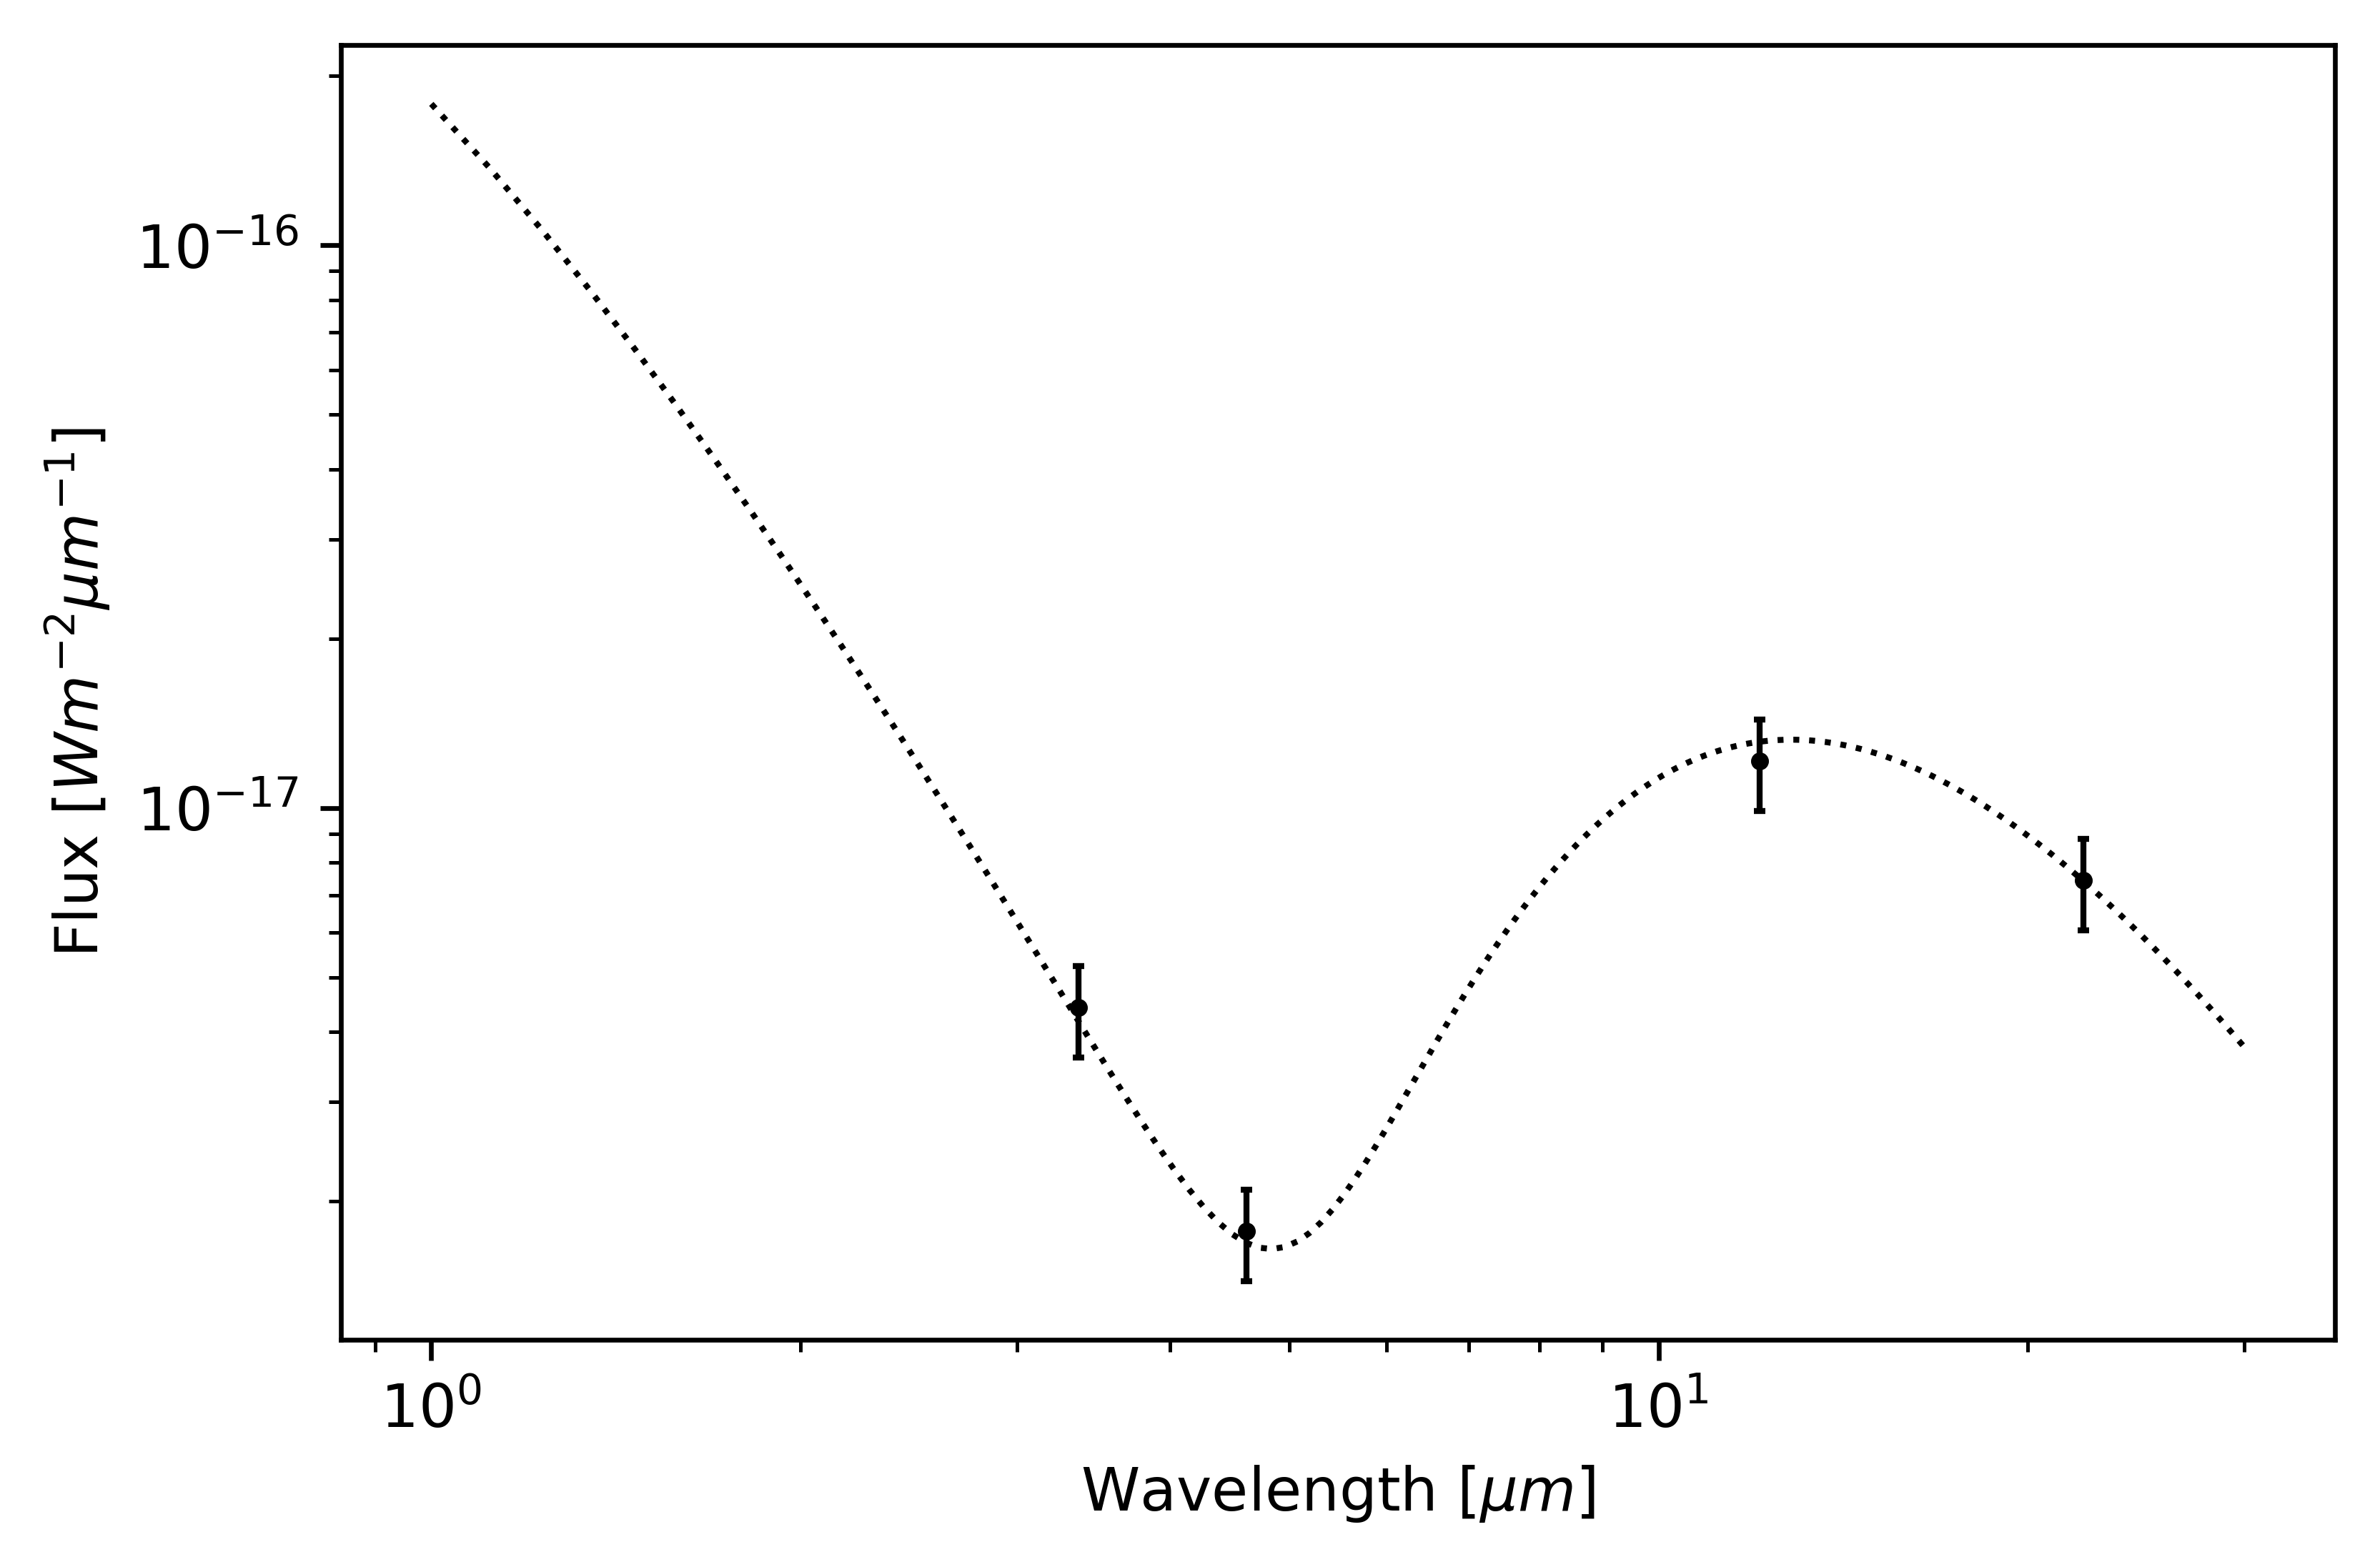

In [34]:
fig, ax = plt.subplots(1, 1, dpi=DPI)
plotSED(SED_neatm, ax=ax)
plotObservations(obs, data, 
                 ax=ax, 
                 plotMedian=True, 
                 columnMapping=columnMapping)

Fitting 0000 with STM...
Fit Code: 1
Fit Parameters: ['logT1', 'logD', 'eps_W1W2']
Emissivity Parameters: ['eps_W1W2' 'eps_W3W4']
Emissivity Specification: {'eps_W1W2': ['W1', 'W2'], 'eps_W3W4': ['W3', 'W4']}
Albedo Parameters: ['p_W1W2' 'p_W3W4']
Albedo Specification: auto
Number of observations: 1
Ignoring data parameters: ['logT1', 'logD', 'eps_W1W2']
Chains: 10
Samples per Chain: 3000
Burn-in Samples: 500
Effective Samples per Chain: 2500
Threads: 10


Multiprocess sampling (10 chains in 10 jobs)
CompoundStep
>Metropolis: [eps_W1W2]
>Metropolis: [logT1]
>Metropolis: [logD]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Found best fit parameters:
 logT1:    2.646 +- 0.058
 logD:     2.948 +- 0.138
 eps_W1W2: 0.631 +- 0.258
Total time: 29.19 seconds
Done.



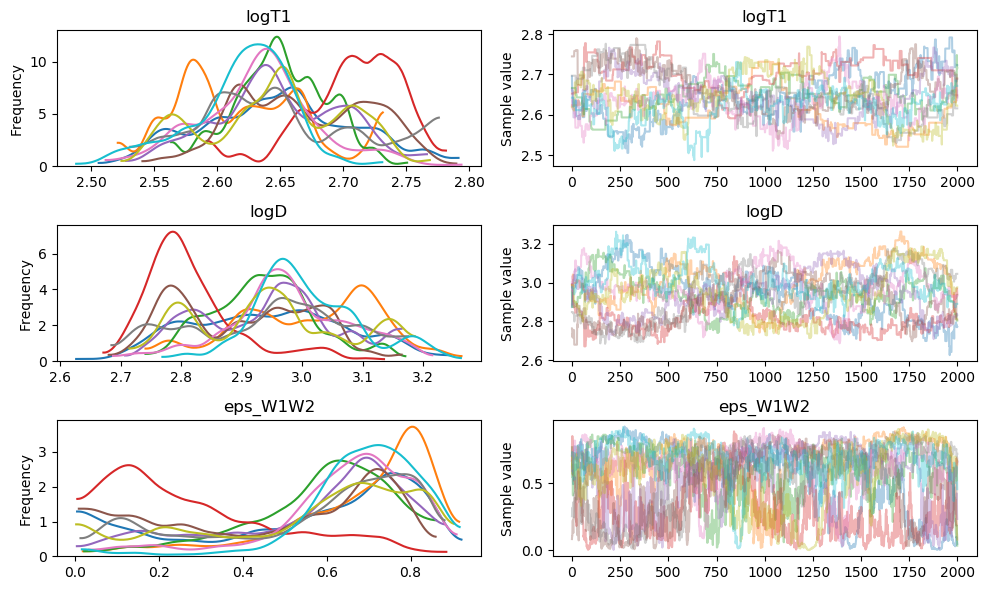

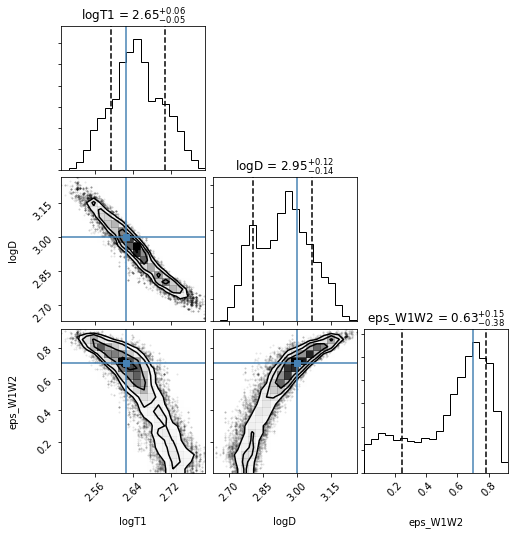

In [35]:
# Run STM
model = STM(verbose=False)
summary_stm, model_observations_stm, pymc_objs_stm = fit(
    model, 
    obs, 
    data,
    fitParameters=fitParameters, 
    fitFilters=fitFilters,
    emissivitySpecification=emissivitySpecification, 
    albedoSpecification=albedoSpecification,
    columnMapping=columnMapping,
    verbose=False)

Fitting 0000 with FRM...
Fit Code: 1
Fit Parameters: ['logT1', 'logD', 'eps_W1W2']
Emissivity Parameters: ['eps_W1W2' 'eps_W3W4']
Emissivity Specification: {'eps_W1W2': ['W1', 'W2'], 'eps_W3W4': ['W3', 'W4']}
Albedo Parameters: ['p_W1W2' 'p_W3W4']
Albedo Specification: auto
Number of observations: 1
Ignoring data parameters: ['logT1', 'logD', 'eps_W1W2']
Chains: 10
Samples per Chain: 3000
Burn-in Samples: 500
Effective Samples per Chain: 2500
Threads: 10


Multiprocess sampling (10 chains in 10 jobs)
CompoundStep
>Metropolis: [eps_W1W2]
>Metropolis: [logT1]
>Metropolis: [logD]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Found best fit parameters:
 logT1:    2.622 +- 0.047
 logD:     2.941 +- 0.105
 eps_W1W2: 0.617 +- 0.189
Total time: 29.49 seconds
Done.



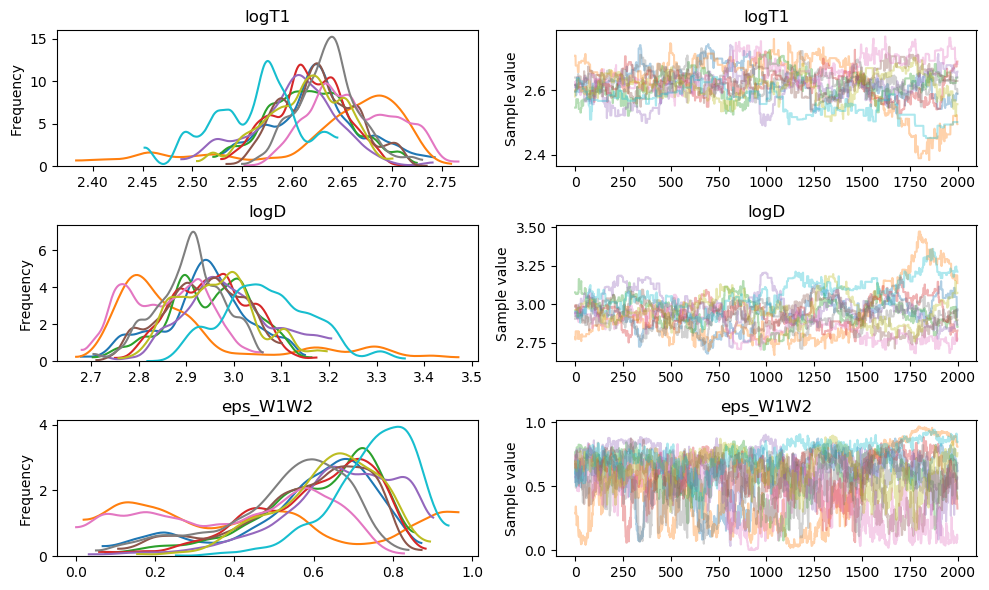

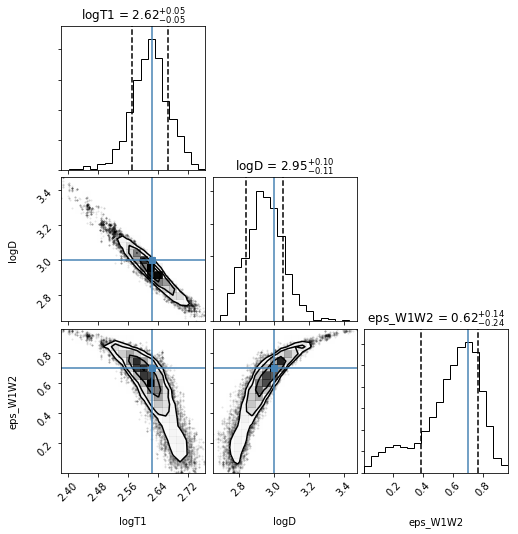

In [36]:
# Run FRM
model = FRM(verbose=False)
summary_frm, model_observations_frm, pymc_objs_frm = fit(
    model, 
    obs, 
    data, 
    fitParameters=fitParameters, 
    emissivitySpecification=emissivitySpecification, 
    albedoSpecification=albedoSpecification,
    columnMapping=columnMapping,
    verbose=False)

Fitting 0000 with NEATM...
Fit Code: 1
Fit Parameters: ['logT1', 'logD', 'eps_W1W2']
Emissivity Parameters: ['eps_W1W2' 'eps_W3W4']
Emissivity Specification: {'eps_W1W2': ['W1', 'W2'], 'eps_W3W4': ['W3', 'W4']}
Albedo Parameters: ['p_W1W2' 'p_W3W4']
Albedo Specification: auto
Number of observations: 1
Ignoring data parameters: ['logT1', 'logD', 'eps_W1W2']
Chains: 10
Samples per Chain: 3000
Burn-in Samples: 500
Effective Samples per Chain: 2500
Threads: 10


Multiprocess sampling (10 chains in 10 jobs)
CompoundStep
>Metropolis: [eps_W1W2]
>Metropolis: [logT1]
>Metropolis: [logD]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Found best fit parameters:
 logT1:    2.651 +- 0.049
 logD:     2.932 +- 0.114
 eps_W1W2: 0.606 +- 0.229
Total time: 29.99 seconds
Done.



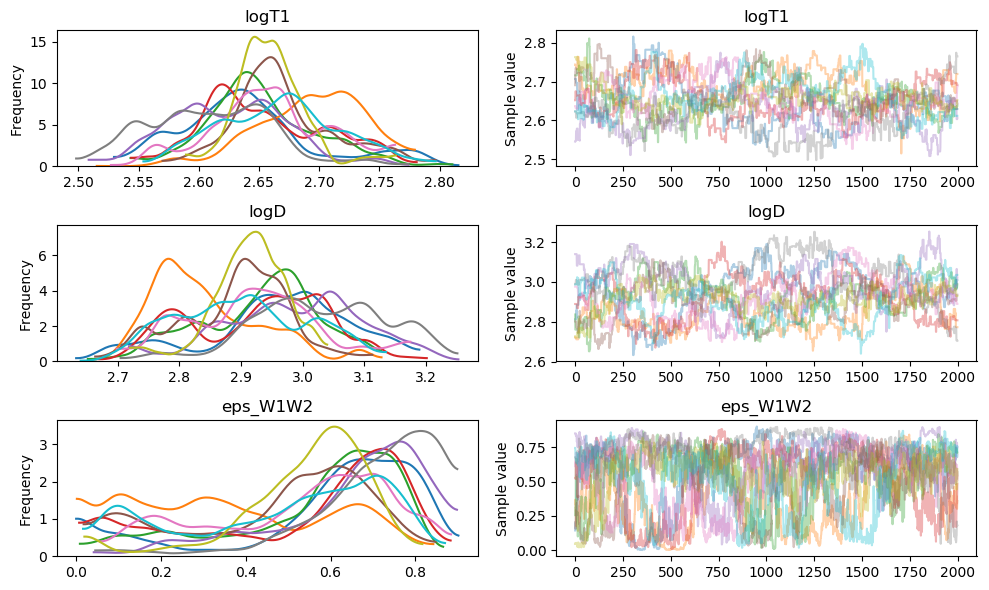

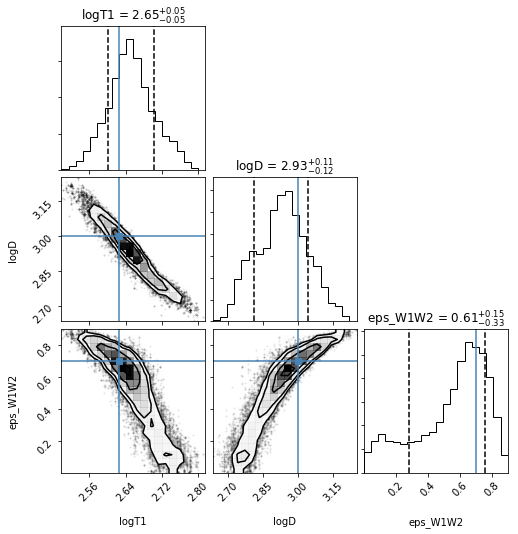

In [37]:
# Run NEATM
model = NEATM(verbose=False)
summary_neatm, model_observations_neatm, pymc_objs_neatm, figs = fit(
    model, 
    obs, 
    data, 
    fitParameters=fitParameters, 
    emissivitySpecification=emissivitySpecification,
    albedoSpecification=albedoSpecification,
    columnMapping=columnMapping,
    returnFigs=True,
    verbose=False)
if SAVE_FIGS is True:
    fig_corner = figs[1]
    fig_corner.savefig(os.path.join(SAVE_DIR, "validation_synthetic_1obs_3param_NEATM_corner".format(FORMAT)), 
                       bbox_inches='tight',
                       dpi=DPI)

In [38]:
# Truth parameters
data[fitParameters]

logT1  logD  eps_W1W2
0  2.625312   3.0       0.7

In [39]:
# Fitting results
summary_stm

designation model  code parameter    median    sigmaG      mean        sd  \
0        0000   STM     1     logT1  2.645680  0.057524  2.648311  0.055747   
1        0000   STM     1      logD  2.948117  0.137501  2.940895  0.120739   
2        0000   STM     1  eps_W1W2  0.631302  0.258099  0.555377  0.241304   

   mc_error      n_eff      Rhat   hpd_2.5  hpd_97.5  
0  0.004954  66.720841  1.090588  2.544664  2.752534  
1  0.010812  66.765080  1.090321  2.727522  3.159563  
2  0.020755  67.635678  1.086672  0.070843  0.878134

In [40]:
# Fitting results
summary_frm

designation model  code parameter    median    sigmaG      mean        sd  \
0        0000   FRM     1     logT1  2.622230  0.047160  2.618752  0.052923   
1        0000   FRM     1      logD  2.941230  0.104965  2.947890  0.113853   
2        0000   FRM     1  eps_W1W2  0.617201  0.188532  0.576603  0.201731   

   mc_error      n_eff      Rhat   hpd_2.5  hpd_97.5  
0  0.004578  36.399124  1.139708  2.518501  2.724734  
1  0.009873  37.080705  1.139813  2.736581  3.168739  
2  0.016482  39.171759  1.136380  0.111535  0.874491

In [41]:
# Fitting results
summary_neatm

designation  model  code parameter    median    sigmaG      mean        sd  \
0        0000  NEATM     1     logT1  2.651211  0.048530  2.652802  0.052356   
1        0000  NEATM     1      logD  2.931796  0.114176  2.929518  0.111731   
2        0000  NEATM     1  eps_W1W2  0.605579  0.229194  0.542316  0.226608   

   mc_error      n_eff      Rhat   hpd_2.5  hpd_97.5  
0  0.004416  78.902011  1.108793  2.554375  2.762066  
1  0.009547  76.845926  1.113161  2.712074  3.135974  
2  0.018728  92.757720  1.080092  0.065459  0.858090

In [42]:
# Use best-fit parameters to model fluxes
model = STM(verbose=False)

SED_stm_fit = calcFluxLambdaSED(model, obs, data,
                                summary=summary_stm,
                                fitParameters=fitParameters,
                                emissivitySpecification=emissivitySpecification,
                                albedoSpecification=albedoSpecification,
                                columnMapping=columnMapping,
                                lambdaRange=lambdaRange,
                                lambdaNum=lambdaNum,
                                lambdaEdges=lambdaEdges,
                                linearInterpolation=linearInterpolation)   

# Use best-fit parameters to model fluxes
model = FRM(verbose=False)

SED_frm_fit = calcFluxLambdaSED(model, obs, data,
                                summary=summary_frm,
                                fitParameters=fitParameters,
                                emissivitySpecification=emissivitySpecification,
                                albedoSpecification=albedoSpecification,
                                columnMapping=columnMapping,
                                lambdaRange=lambdaRange,
                                lambdaNum=lambdaNum,
                                lambdaEdges=lambdaEdges,
                                linearInterpolation=linearInterpolation)       

# Use best-fit parameters to model fluxes
model = NEATM(verbose=False)

SED_neatm_fit = calcFluxLambdaSED(model, obs, data,
                                  summary=summary_neatm,
                                  fitParameters=fitParameters,
                                  emissivitySpecification=emissivitySpecification,
                                  albedoSpecification=albedoSpecification,
                                  columnMapping=columnMapping,
                                  lambdaRange=lambdaRange,
                                  lambdaNum=lambdaNum,
                                  lambdaEdges=lambdaEdges,
                                  linearInterpolation=linearInterpolation)       


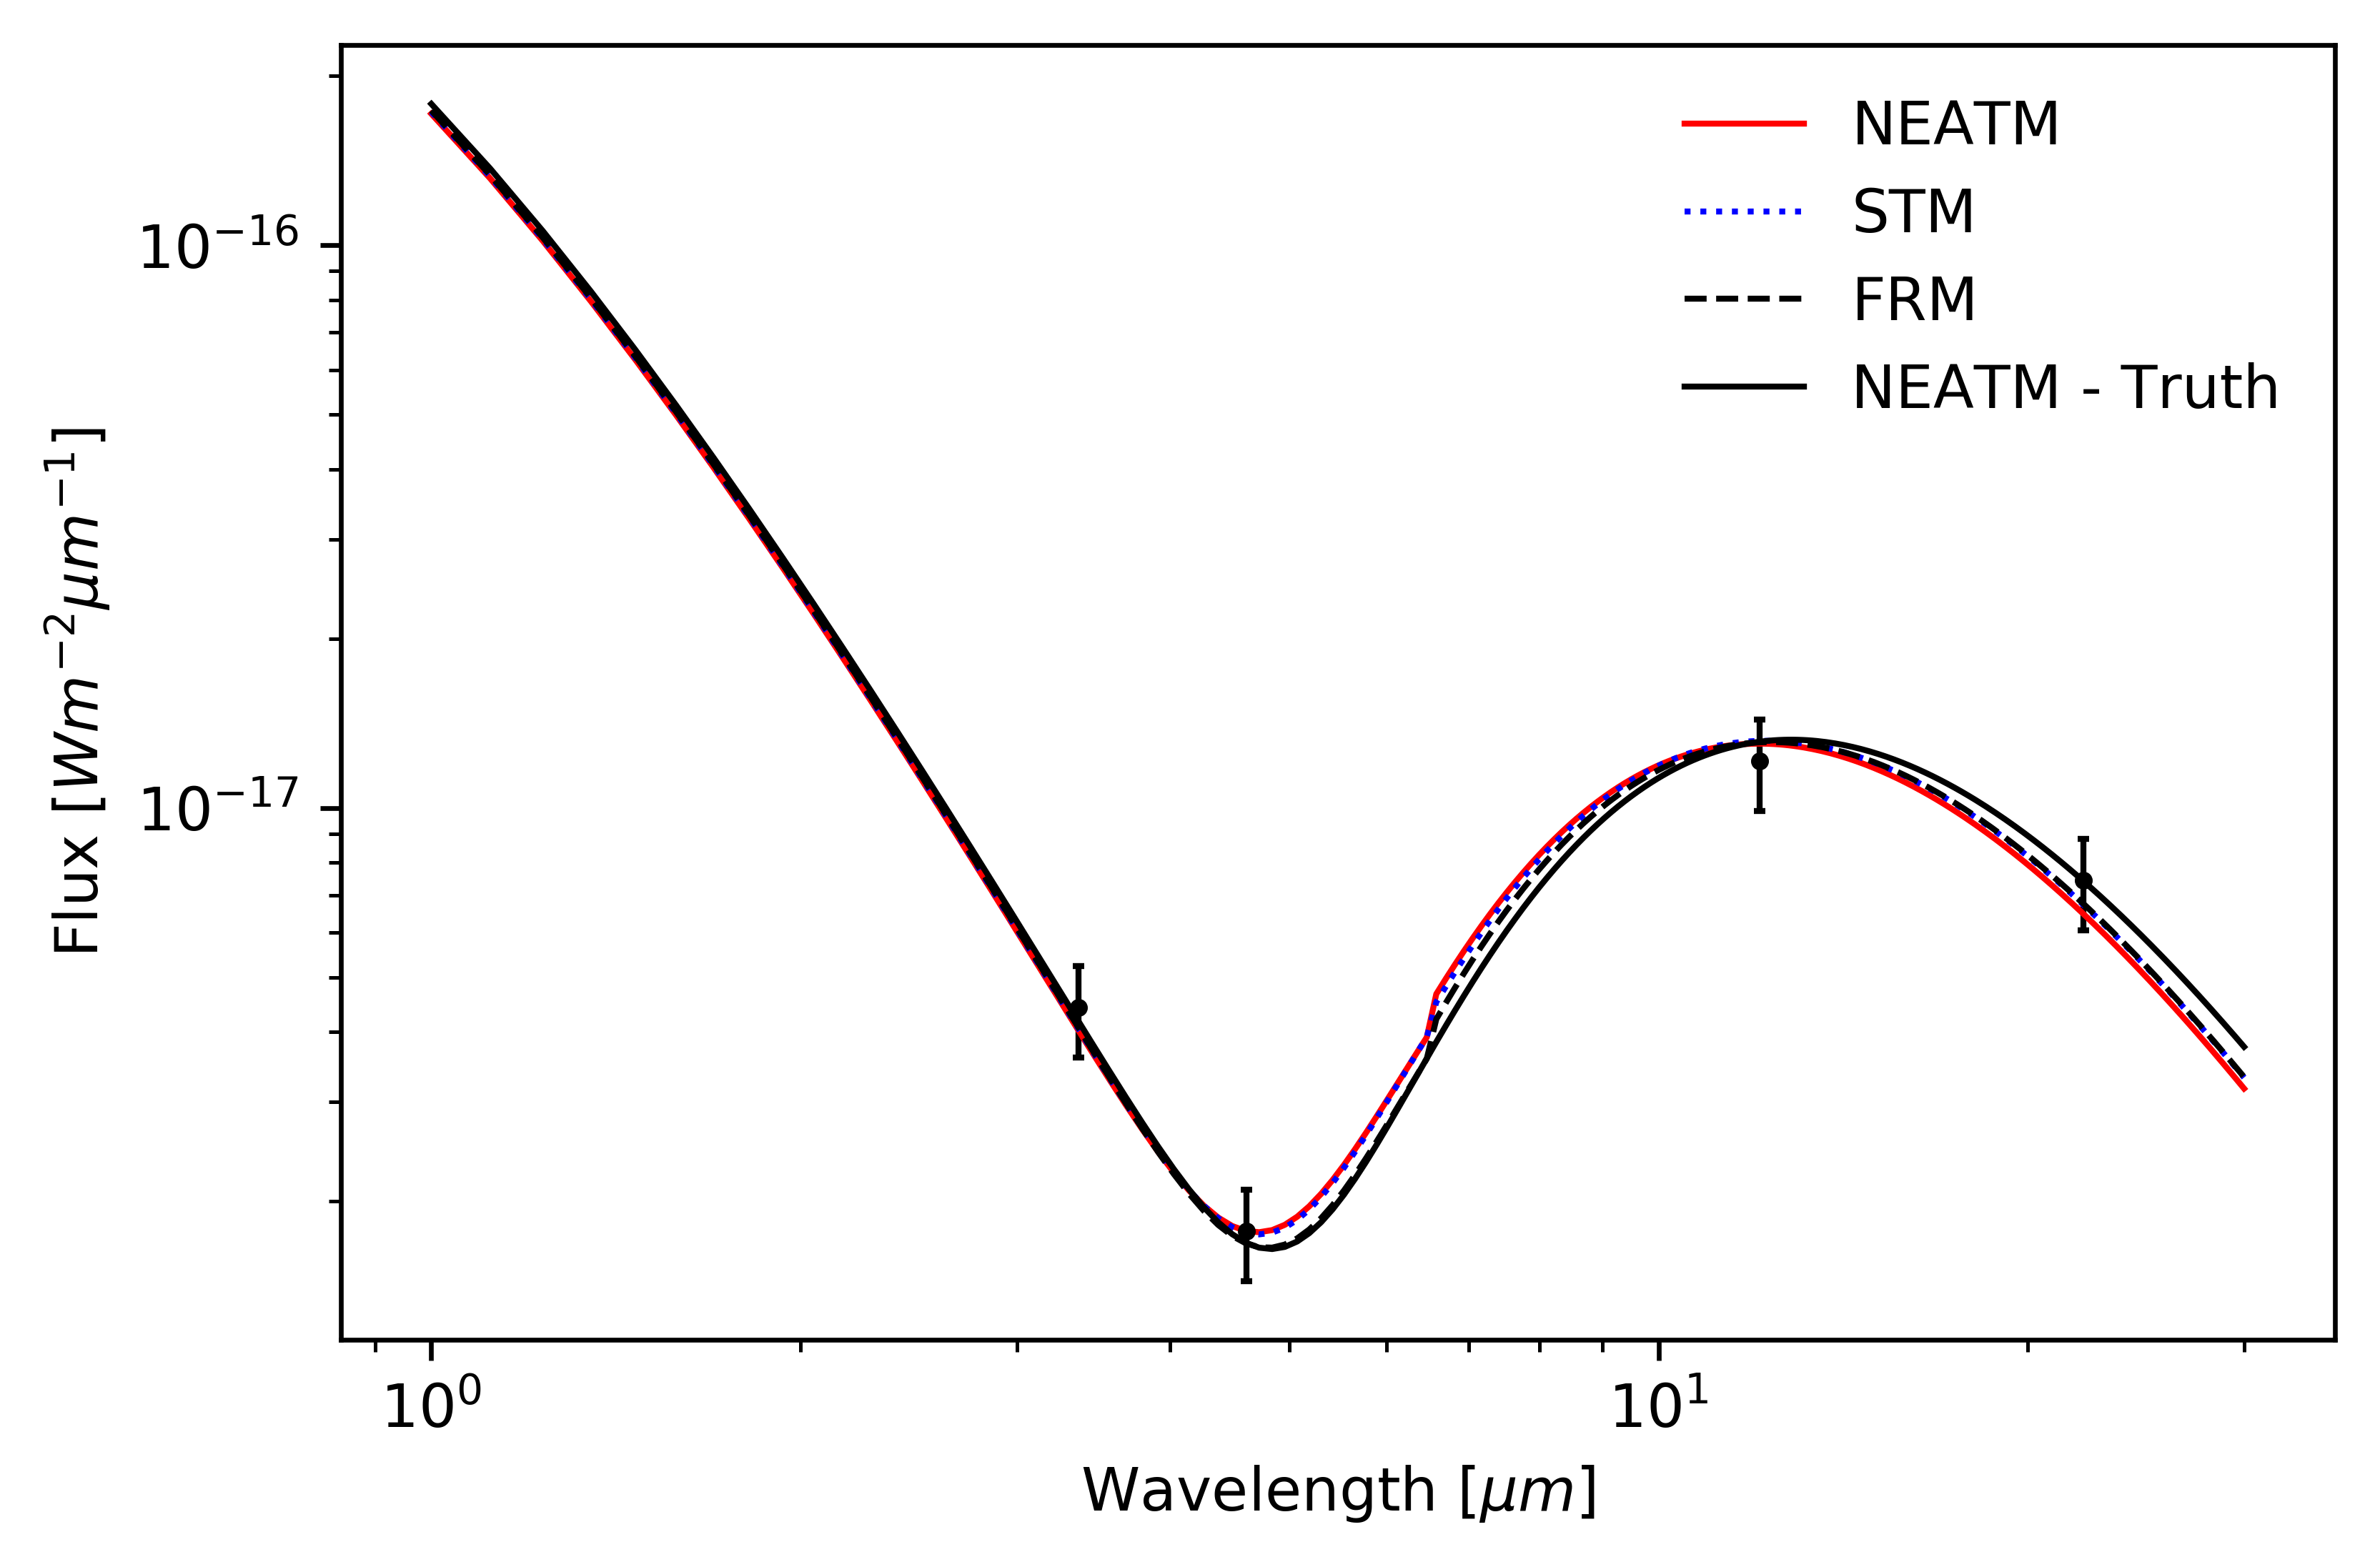

In [43]:
fig, ax = plt.subplots(1, 1, dpi=DPI)
plotSED(SED_neatm_fit, 
        ax=ax, 
        plotKwargs={"label": "NEATM", 
                    "c": "r", 
                    "lw": 1})
plotSED(SED_stm_fit, 
        ax=ax, 
        plotKwargs={"label": "STM", 
                    "c": "b", 
                    "ls": ":", 
                    "lw": 1})
plotSED(SED_frm_fit, 
        ax=ax, 
        plotKwargs={"label": "FRM", 
                    "c": "k", 
                    "ls": "--", 
                    "lw": 1})
plotSED(SED_neatm, 
        ax=ax, 
        plotKwargs={"label":"NEATM - Truth", 
                    "c" : "k" , 
                    "lw": 1})
plotObservations(obs, data, 
                 ax=ax, 
                 plotMedian=True, 
                 columnMapping=columnMapping)
ax.legend(frameon=False)
if SAVE_FIGS is True:
    fig.savefig(os.path.join(SAVE_DIR, "validation_synthetic_1obs_3param_SEDs".format(FORMAT)), 
                bbox_inches='tight',
                dpi=DPI)

### Case 3: 25 Observations 3 Parameters

In [44]:
# Instantiate observatory and NEATM class for simulating data
obs = WISE()
model = NEATM(verbose=False)

In [45]:
# Load WISE quadrature lookup tables into memory 
model.loadLambdaTables(obs.filterQuadratureLambdas, verbose=False)

In [46]:
# Create observing geometry
num_obs = 25
r = np.random.normal(loc=3.0, scale=0.01, size=num_obs)
delta = r - 1.0
alpha = np.zeros(num_obs)

In [47]:
# Fractional flux error of 0.1% (will add 0.1 mag Sigma later)
err = 0.001

In [48]:
# Create fake asteroid
# Here we set a value of T1, we could also explicitly calculate T_ss 
#   using atm.functions.calcTss and from there calculate T1, however this is not needed 
#   for this example
G = 0.15 * np.ones(num_obs)
D = 1000 * np.ones(num_obs)
logD = np.log10(D) * np.ones(num_obs)
eps_W3W4 = np.array(0.70) * np.ones(num_obs)
eps_W1W2 = np.array(0.70) * np.ones(num_obs)
p_W1W2 = (1 - eps_W1W2) / calcQ(G)
p_W3W4 = (1 - eps_W3W4) / calcQ(G)
T1 = 422. * np.ones(num_obs)
logT1 = np.log10(T1)
T_ss = T1 / np.sqrt(r)

In [49]:
# Model flux with sunlight
flux = interpFluxLambdaObsWithSunlight(model, obs, r, delta, T_ss, D, alpha, eps, p, G).T
fluxErr = err * flux
mag = obs.convertFluxLambdaToMag(flux)
magErr = obs.convertFluxLambdaErrToMagErr(flux, fluxErr)

data = np.vstack([r, delta, alpha, G, D, logD, T1, logT1, T_ss,
                  flux[:, 0], flux[:, 1], flux[:, 2], flux[:, 3],
                  fluxErr[:, 0], fluxErr[:, 1], fluxErr[:, 2], fluxErr[:, 3],
                  mag[:, 0], mag[:, 1], mag[:, 2], mag[:, 3],
                  magErr[:, 0], magErr[:, 1], magErr[:, 2], magErr[:, 3]])

data = pd.DataFrame(data.T, columns=["r",
                                     "delta",
                                     "alpha",
                                     "G",
                                     "D",
                                     "logD",
                                     "T1",
                                     "logT1",
                                     "T_ss",
                                     "flux_W1_si",
                                     "flux_W2_si",
                                     "flux_W3_si",
                                     "flux_W4_si",
                                     "fluxErr_W1_si",
                                     "fluxErr_W2_si",
                                     "fluxErr_W3_si",
                                     "fluxErr_W4_si",
                                     "mag_W1",
                                     "mag_W2",
                                     "mag_W3",
                                     "mag_W4",
                                     "magErr_W1",
                                     "magErr_W2",
                                     "magErr_W3",
                                     "magErr_W4"])
data["obs_id"] = np.arange(1, len(data) + 1)
data["eps_W3W4"] = eps_W3W4
data["eps_W1W2"] = eps_W1W2
data["p_W1W2"] = p_W1W2
data["p_W3W4"] = p_W3W4
data["designation"] = ["0000" for i in range(len(data))]
data = data[["obs_id", "designation", "r", "delta", "alpha", "G", "D", "logD", "T1", "logT1", "T_ss", 
             "eps_W1W2", "eps_W3W4", "p_W1W2", "p_W3W4",
             "flux_W1_si", "flux_W2_si", "flux_W3_si", "flux_W4_si", 
             "fluxErr_W1_si", "fluxErr_W2_si", "fluxErr_W3_si", "fluxErr_W4_si",
             "mag_W1", "mag_W2", "mag_W3", "mag_W4",
             "magErr_W1", "magErr_W2", "magErr_W3", "magErr_W4"]]

In [50]:
columnMapping = {
    "designation" : "designation",
    "obs_id" : "obs_id",
    "r_au" : "r",
    "delta_au" : "delta",
    "alpha_rad" : "alpha",
    "G" : "G",
    "logT1" : "logT1",
    "logD": "logD",
    "eps" : ["eps_W1W2", "eps_W3W4"],
    "p" : ["p_W1W2", "p_W3W4"],
    "flux_si": ["flux_W1_si", "flux_W2_si", "flux_W3_si", "flux_W4_si"],
    "fluxErr_si": ["fluxErr_W1_si", "fluxErr_W2_si", "fluxErr_W3_si", "fluxErr_W4_si"],
    "mag" : ["mag_W1", "mag_W2", "mag_W3", "mag_W4"],
    "magErr" : ["magErr_W1", "magErr_W2", "magErr_W3", "magErr_W4"]
}
fitParameters = ["logT1", "logD", "eps_W1W2"]
fitFilters = "all"
emissivitySpecification = {"eps_W1W2" : ["W1", "W2"],
                           "eps_W3W4" : ["W3", "W4"]}
albedoSpecification = "auto"

# Wavelength config for calculating SEDs
lambdaRange=[1e-6, 30e-6]
lambdaNum=250
lambdaEdges=[3.9e-6, 6.5e-6, 18.5e-6]
linearInterpolation=False

In [51]:
# Modify errors: add sigma of 0.1 mag to account for rotation (assumed better observed than Case 1 and 2)
data = modifyErrors(data, obs, sigma=0.1, columnMapping=columnMapping)

Added 0.1 magnitude errors to magErr_W1.
Added 0.1 magnitude errors to magErr_W2.
Added 0.1 magnitude errors to magErr_W3.
Added 0.1 magnitude errors to magErr_W4.
Converted magnitude errors to flux errors.
Updating fluxErr_W1_si with new error.
Updating fluxErr_W2_si with new error.
Updating fluxErr_W3_si with new error.
Updating fluxErr_W4_si with new error.
Done.



In [52]:
data

obs_id designation         r     delta  alpha     G       D  logD     T1  \
0        1        0000  2.992604  1.992604    0.0  0.15  1000.0   3.0  422.0   
1        2        0000  3.013385  2.013385    0.0  0.15  1000.0   3.0  422.0   
2        3        0000  2.979160  1.979160    0.0  0.15  1000.0   3.0  422.0   
3        4        0000  3.008870  2.008870    0.0  0.15  1000.0   3.0  422.0   
4        5        0000  3.016455  2.016455    0.0  0.15  1000.0   3.0  422.0   
5        6        0000  2.989848  1.989848    0.0  0.15  1000.0   3.0  422.0   
6        7        0000  2.996130  1.996130    0.0  0.15  1000.0   3.0  422.0   
7        8        0000  3.004863  2.004863    0.0  0.15  1000.0   3.0  422.0   
8        9        0000  2.992182  1.992182    0.0  0.15  1000.0   3.0  422.0   
9       10        0000  3.012681  2.012681    0.0  0.15  1000.0   3.0  422.0   
10      11        0000  3.007562  2.007562    0.0  0.15  1000.0   3.0  422.0   
11      12        0000  2.984185  1.984185    0.0  0.15  1000.0   3.0  422.0   
12      13        0000  2.991443  1.991443    0.0  0.15  1000.0   3.0  422.0   
13      14        0000  3.016471  2.016471    0.0  0.15  1000.0   3.0  422.0   
14      15        0000  3.003346  2.003346    0.0  0.15  1000.0   3.0  422.0   
15      16        0000  3.006666  2.006666    0.0  0.15  1000.0   3.0  422.0   
16      17        0000  2.997045  1.997045    0.0  0.15  1000.0   3.0  422.0   
17      18        0000  2.990128  1.990128    0.0  0.15  1000.0   3.0  422.0   
18      19        0000  3.002509  2.002509    0.0  0.15  1000.0   3.0  422.0   
19      20        0000  3.002690  2.002690    0.0  0.15  1000.0   3.0  422.0   
20      21        0000  3.006793  2.006793    0.0  0.15  1000.0   3.0  422.0   
21      22        0000  3.000119  2.000119    0.0  0.15  1000.0   3.0  422.0   
22      23        0000  3.016923  2.016923    0.0  0.15  1000.0   3.0  422.0   
23      24        0000  3.016740  2.016740    0.0  0.15  1000.0   3.0  422.0   
24      25        0000  3.010484  2.010484    0.0  0.15  1000.0   3.0  422.0   

       logT1  ...  fluxErr_W3_si  fluxErr_W4_si     mag_W1     mag_W2  \
0   2.625312  ...   1.136217e-12   6.965083e-13  18.153764  17.822231   
1   2.625312  ...   1.093348e-12   6.748554e-13  18.191516  17.867378   
2   2.625312  ...   1.165024e-12   7.109844e-13  18.129155  17.792735   
3   2.625312  ...   1.102494e-12   6.794862e-13  18.183345  17.857616   
4   2.625312  ...   1.087180e-12   6.717286e-13  18.197064  17.874003   
5   2.625312  ...   1.142052e-12   6.994455e-13  18.148731  17.816203   
6   2.625312  ...   1.128803e-12   6.927733e-13  18.160194  17.829929   
7   2.625312  ...   1.110689e-12   6.836308e-13  18.176077  17.848929   
8   2.625312  ...   1.137107e-12   6.969567e-13  18.152995  17.821309   
9   2.625312  ...   1.094767e-12   6.755744e-13  18.190244  17.865858   
10  2.625312  ...   1.105161e-12   6.808354e-13  18.180974  17.854783   
11  2.625312  ...   1.154154e-12   7.055288e-13  18.138372  17.803788   
12  2.625312  ...   1.138670e-12   6.977432e-13  18.151646  17.819694   
13  2.625312  ...   1.087148e-12   6.717125e-13  18.197093  17.874037   
14  2.625312  ...   1.113809e-12   6.852072e-13  18.173324  17.845637   
15  2.625312  ...   1.106993e-12   6.817622e-13  18.179348  17.852840   
16  2.625312  ...   1.126888e-12   6.918076e-13  18.161862  17.831926   
17  2.625312  ...   1.141456e-12   6.991456e-13  18.149244  17.816817   
18  2.625312  ...   1.115536e-12   6.860794e-13  18.171803  17.843819   
19  2.625312  ...   1.115164e-12   6.858912e-13  18.172131  17.844211   
20  2.625312  ...   1.106732e-12   6.816301e-13  18.179580  17.853117   
21  2.625312  ...   1.120485e-12   6.885779e-13  18.167457  17.838621   
22  2.625312  ...   1.086242e-12   6.712531e-13  18.197910  17.875012   
23  2.625312  ...   1.086610e-12   6.714395e-13  18.197579  17.874616   
24  2.625312  ...   1.099215e-12   6.778266e-13  18.186267  17.861108   

       mag_W3    mag_W4 

In [53]:
# Generate truth at a variety of wavelengths for plotting
model = NEATM(verbose=False)

SED_neatm = calcFluxLambdaSED(model, obs, data,
                              emissivitySpecification=emissivitySpecification,
                              albedoSpecification=albedoSpecification,
                              columnMapping=columnMapping,
                              lambdaRange=lambdaRange,
                              lambdaNum=lambdaNum,
                              lambdaEdges=lambdaEdges,
                              linearInterpolation=linearInterpolation)   

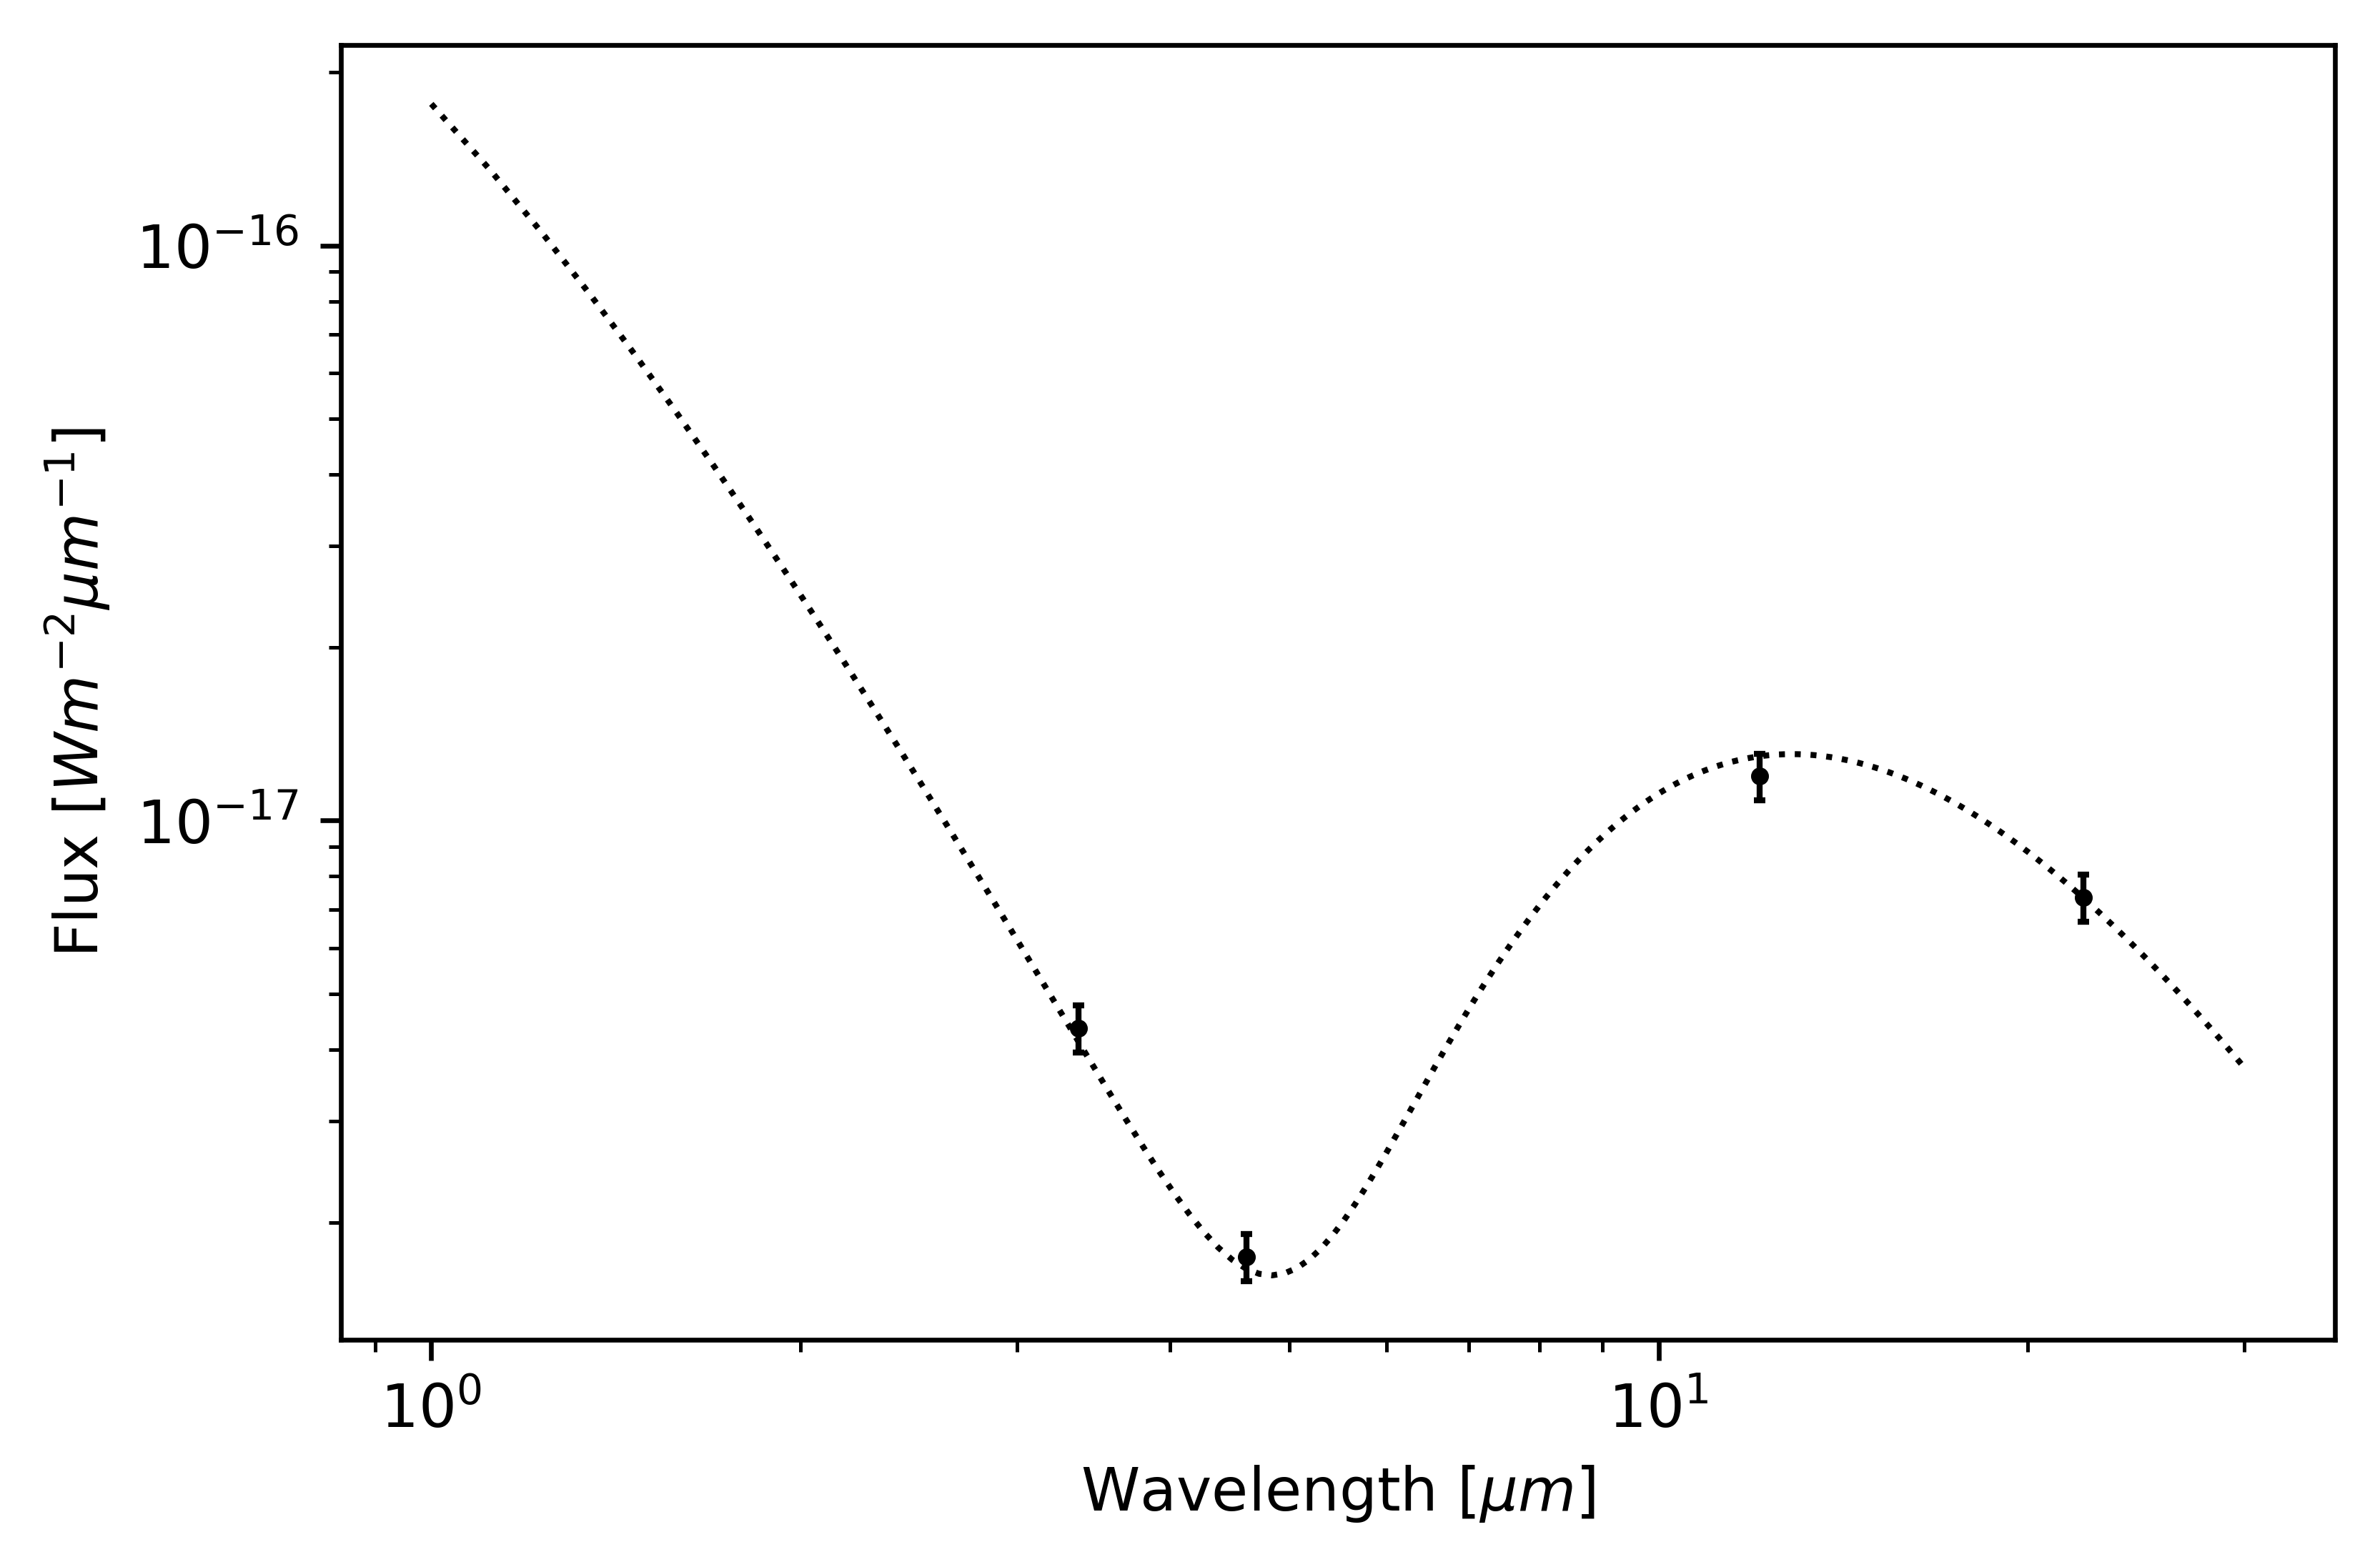

In [54]:
fig, ax = plt.subplots(1, 1, dpi=DPI)
plotSED(SED_neatm, ax=ax)
plotObservations(obs, data, 
                 ax=ax, 
                 plotMedian=True, 
                 columnMapping=columnMapping)

Fitting 0000 with STM...
Fit Code: 1
Fit Parameters: ['logT1', 'logD', 'eps_W1W2']
Emissivity Parameters: ['eps_W1W2' 'eps_W3W4']
Emissivity Specification: {'eps_W1W2': ['W1', 'W2'], 'eps_W3W4': ['W3', 'W4']}
Albedo Parameters: ['p_W1W2' 'p_W3W4']
Albedo Specification: auto
Number of observations: 25
Ignoring data parameters: ['logT1', 'logD', 'eps_W1W2']
Chains: 10
Samples per Chain: 3000
Burn-in Samples: 500
Effective Samples per Chain: 2500
Threads: 10


Multiprocess sampling (10 chains in 10 jobs)
CompoundStep
>Metropolis: [eps_W1W2]
>Metropolis: [logT1]
>Metropolis: [logD]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


Found best fit parameters:
 logT1:    2.625 +- 0.005
 logD:     3.001 +- 0.010
 eps_W1W2: 0.701 +- 0.013
Total time: 32.13 seconds
Done.



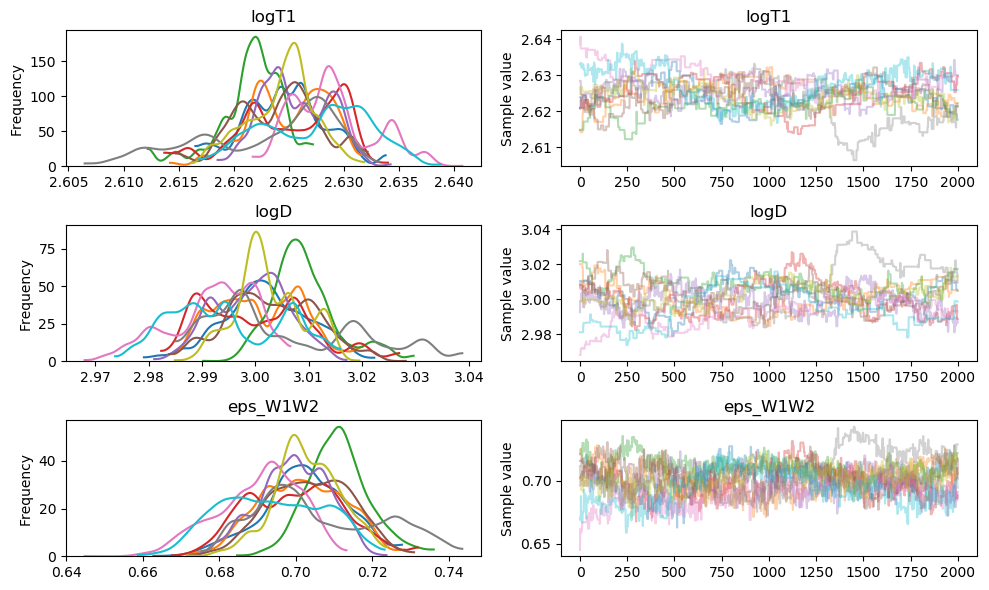

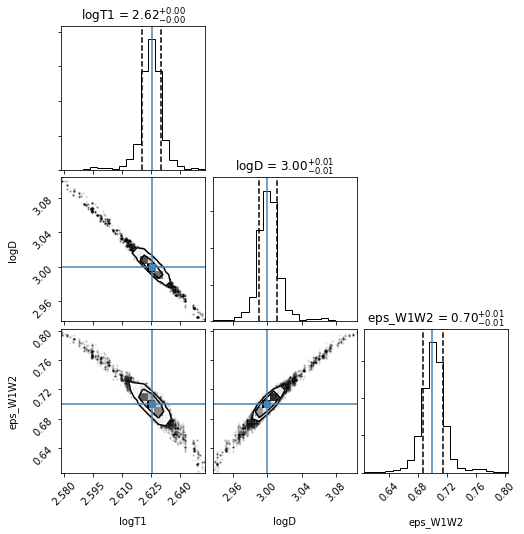

In [55]:
# Run STM
model = STM(verbose=False)
summary_stm, model_observations_stm, pymc_objs_stm = fit(
    model, 
    obs, 
    data,
    fitParameters=fitParameters, 
    fitFilters=fitFilters,
    emissivitySpecification=emissivitySpecification, 
    albedoSpecification=albedoSpecification,
    columnMapping=columnMapping,
    verbose=False)

Fitting 0000 with FRM...
Fit Code: 1
Fit Parameters: ['logT1', 'logD', 'eps_W1W2']
Emissivity Parameters: ['eps_W1W2' 'eps_W3W4']
Emissivity Specification: {'eps_W1W2': ['W1', 'W2'], 'eps_W3W4': ['W3', 'W4']}
Albedo Parameters: ['p_W1W2' 'p_W3W4']
Albedo Specification: auto
Number of observations: 25
Ignoring data parameters: ['logT1', 'logD', 'eps_W1W2']
Chains: 10
Samples per Chain: 3000
Burn-in Samples: 500
Effective Samples per Chain: 2500
Threads: 10


Multiprocess sampling (10 chains in 10 jobs)
CompoundStep
>Metropolis: [eps_W1W2]
>Metropolis: [logT1]
>Metropolis: [logD]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Found best fit parameters:
 logT1:    2.606 +- 0.007
 logD:     2.985 +- 0.014
 eps_W1W2: 0.675 +- 0.019
Total time: 31.82 seconds
Done.



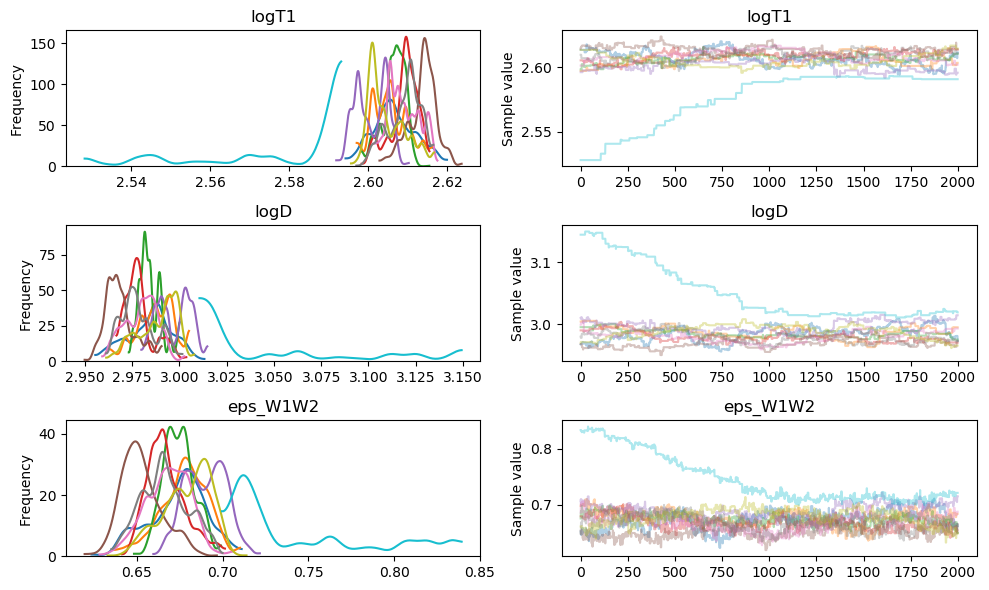

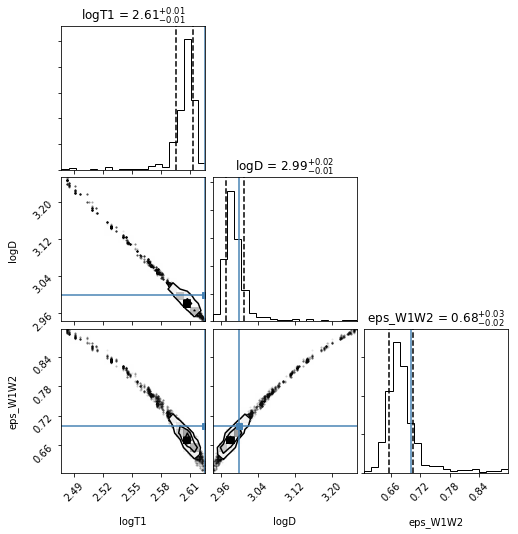

In [56]:
# Run FRM
model = FRM(verbose=False)
summary_frm, model_observations_frm, pymc_objs_frm = fit(
    model, 
    obs, 
    data, 
    fitParameters=fitParameters, 
    emissivitySpecification=emissivitySpecification, 
    albedoSpecification=albedoSpecification,
    columnMapping=columnMapping,
    verbose=False)

Fitting 0000 with NEATM...
Fit Code: 1
Fit Parameters: ['logT1', 'logD', 'eps_W1W2']
Emissivity Parameters: ['eps_W1W2' 'eps_W3W4']
Emissivity Specification: {'eps_W1W2': ['W1', 'W2'], 'eps_W3W4': ['W3', 'W4']}
Albedo Parameters: ['p_W1W2' 'p_W3W4']
Albedo Specification: auto
Number of observations: 25
Ignoring data parameters: ['logT1', 'logD', 'eps_W1W2']
Chains: 10
Samples per Chain: 3000
Burn-in Samples: 500
Effective Samples per Chain: 2500
Threads: 10


Multiprocess sampling (10 chains in 10 jobs)
INFO:pymc3:Multiprocess sampling (10 chains in 10 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>Metropolis: [eps_W1W2]
INFO:pymc3:>Metropolis: [eps_W1W2]
>Metropolis: [logT1]
INFO:pymc3:>Metropolis: [logT1]
>Metropolis: [logD]
INFO:pymc3:>Metropolis: [logD]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
INFO:pymc3:The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


Found best fit parameters:
 logT1:    2.625 +- 0.005
 logD:     2.999 +- 0.011
 eps_W1W2: 0.699 +- 0.014
Total time: 31.93 seconds
Done.



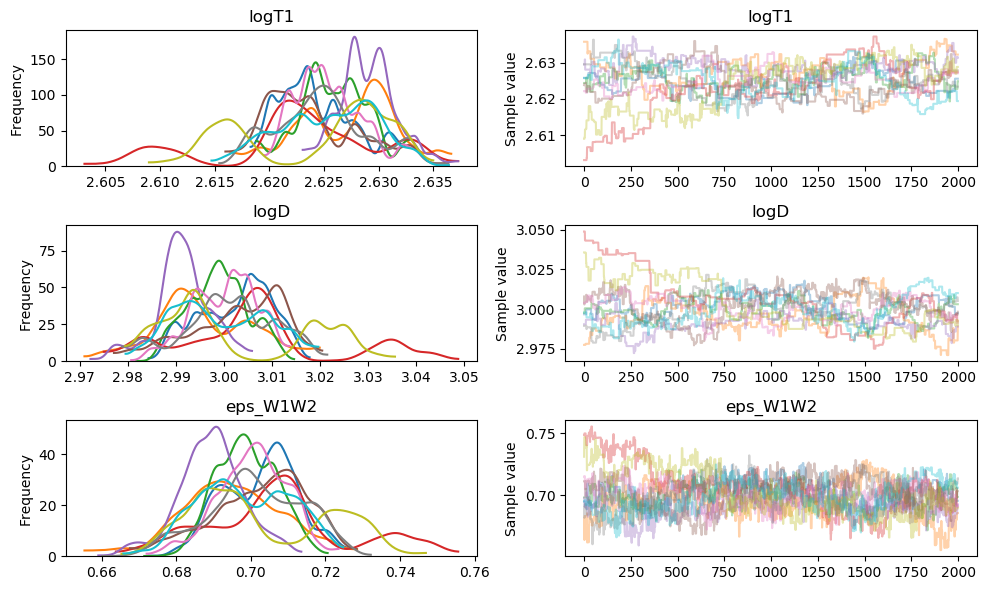

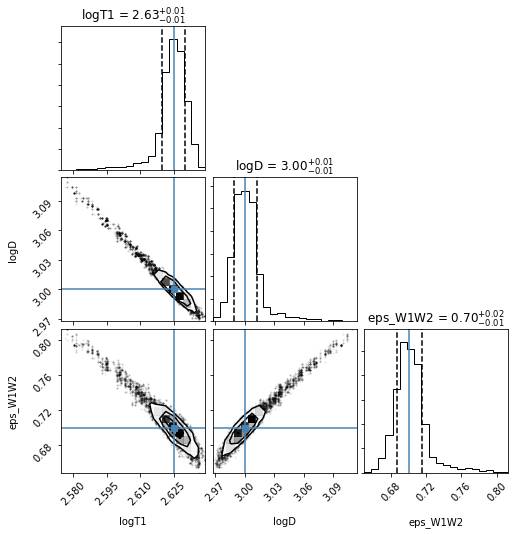

In [57]:
# Run NEATM
model = NEATM(verbose=False)
summary_neatm, model_observations_neatm, pymc_objs_neatm, figs = fit(
    model, 
    obs, 
    data, 
    fitParameters=fitParameters, 
    emissivitySpecification=emissivitySpecification,
    albedoSpecification=albedoSpecification,
    columnMapping=columnMapping,
    returnFigs=True,
    verbose=False)
if SAVE_FIGS is True:
    fig_corner = figs[1]
    fig_corner.savefig(os.path.join(SAVE_DIR, "validation_synthetic_25obs_3param_NEATM_corner".format(FORMAT)), 
                       bbox_inches='tight',
                       dpi=DPI)

In [58]:
# Truth parameters
data[fitParameters]

logT1  logD  eps_W1W2
0   2.625312   3.0       0.7
1   2.625312   3.0       0.7
2   2.625312   3.0       0.7
3   2.625312   3.0       0.7
4   2.625312   3.0       0.7
5   2.625312   3.0       0.7
6   2.625312   3.0       0.7
7   2.625312   3.0       0.7
8   2.625312   3.0       0.7
9   2.625312   3.0       0.7
10  2.625312   3.0       0.7
11  2.625312   3.0       0.7
12  2.625312   3.0       0.7
13  2.625312   3.0       0.7
14  2.625312   3.0       0.7
15  2.625312   3.0       0.7
16  2.625312   3.0       0.7
17  2.625312   3.0       0.7
18  2.625312   3.0       0.7
19  2.625312   3.0       0.7
20  2.625312   3.0       0.7
21  2.625312   3.0       0.7
22  2.625312   3.0       0.7
23  2.625312   3.0       0.7
24  2.625312   3.0       0.7

In [59]:
# Fitting results
summary_stm

designation model  code parameter    median    sigmaG      mean        sd  \
0        0000   STM     1     logT1  2.625012  0.004547  2.624906  0.004510   
1        0000   STM     1      logD  3.000533  0.009997  3.000906  0.010031   
2        0000   STM     1  eps_W1W2  0.701082  0.012545  0.700989  0.012691   

   mc_error      n_eff      Rhat   hpd_2.5  hpd_97.5  
0  0.000401  27.951419  1.186641  2.616620  2.634410  
1  0.000904  26.843652  1.200271  2.979902  3.019364  
2  0.001071  26.801506  1.203723  0.675124  0.725304

In [60]:
# Fitting results
summary_frm

designation model  code parameter    median    sigmaG      mean        sd  \
0        0000   FRM     1     logT1  2.606436  0.006754  2.604042  0.012610   
1        0000   FRM     1      logD  2.984540  0.014157  2.989718  0.026887   
2        0000   FRM     1  eps_W1W2  0.675119  0.019109  0.679448  0.030128   

   mc_error      n_eff      Rhat   hpd_2.5  hpd_97.5  
0  0.001241  12.972798  1.514986  2.588443  2.619907  
1  0.002649  12.938264  1.514824  2.958788  3.026834  
2  0.002919  11.149939  1.557240  0.634386  0.726043

In [61]:
# Fitting results
summary_neatm

designation  model  code parameter    median    sigmaG      mean        sd  \
0        0000  NEATM     1     logT1  2.625445  0.004935  2.625187  0.004932   
1        0000  NEATM     1      logD  2.999124  0.010782  3.000028  0.011099   
2        0000  NEATM     1  eps_W1W2  0.698992  0.013723  0.699685  0.013818   

   mc_error      n_eff      Rhat   hpd_2.5  hpd_97.5  
0  0.000441  27.840759  1.134302  2.615671  2.633695  
1  0.001004  27.476972  1.136666  2.978060  3.019666  
2  0.001174  29.230895  1.129631  0.672749  0.726422

In [62]:
# Use best-fit parameters to model fluxes
model = STM(verbose=False)

SED_stm_fit = calcFluxLambdaSED(model, obs, data,
                                summary=summary_stm,
                                fitParameters=fitParameters,
                                emissivitySpecification=emissivitySpecification,
                                albedoSpecification=albedoSpecification,
                                columnMapping=columnMapping,
                                lambdaRange=lambdaRange,
                                lambdaNum=lambdaNum,
                                lambdaEdges=lambdaEdges,
                                linearInterpolation=linearInterpolation)   

# Use best-fit parameters to model fluxes
model = FRM(verbose=False)

SED_frm_fit = calcFluxLambdaSED(model, obs, data,
                                summary=summary_frm,
                                fitParameters=fitParameters,
                                emissivitySpecification=emissivitySpecification,
                                albedoSpecification=albedoSpecification,
                                columnMapping=columnMapping,
                                lambdaRange=lambdaRange,
                                lambdaNum=lambdaNum,
                                lambdaEdges=lambdaEdges,
                                linearInterpolation=linearInterpolation)       

# Use best-fit parameters to model fluxes
model = NEATM(verbose=False)

SED_neatm_fit = calcFluxLambdaSED(model, obs, data,
                                  summary=summary_neatm,
                                  fitParameters=fitParameters,
                                  emissivitySpecification=emissivitySpecification,
                                  albedoSpecification=albedoSpecification,
                                  columnMapping=columnMapping,
                                  lambdaRange=lambdaRange,
                                  lambdaNum=lambdaNum,
                                  lambdaEdges=lambdaEdges,
                                  linearInterpolation=linearInterpolation)       


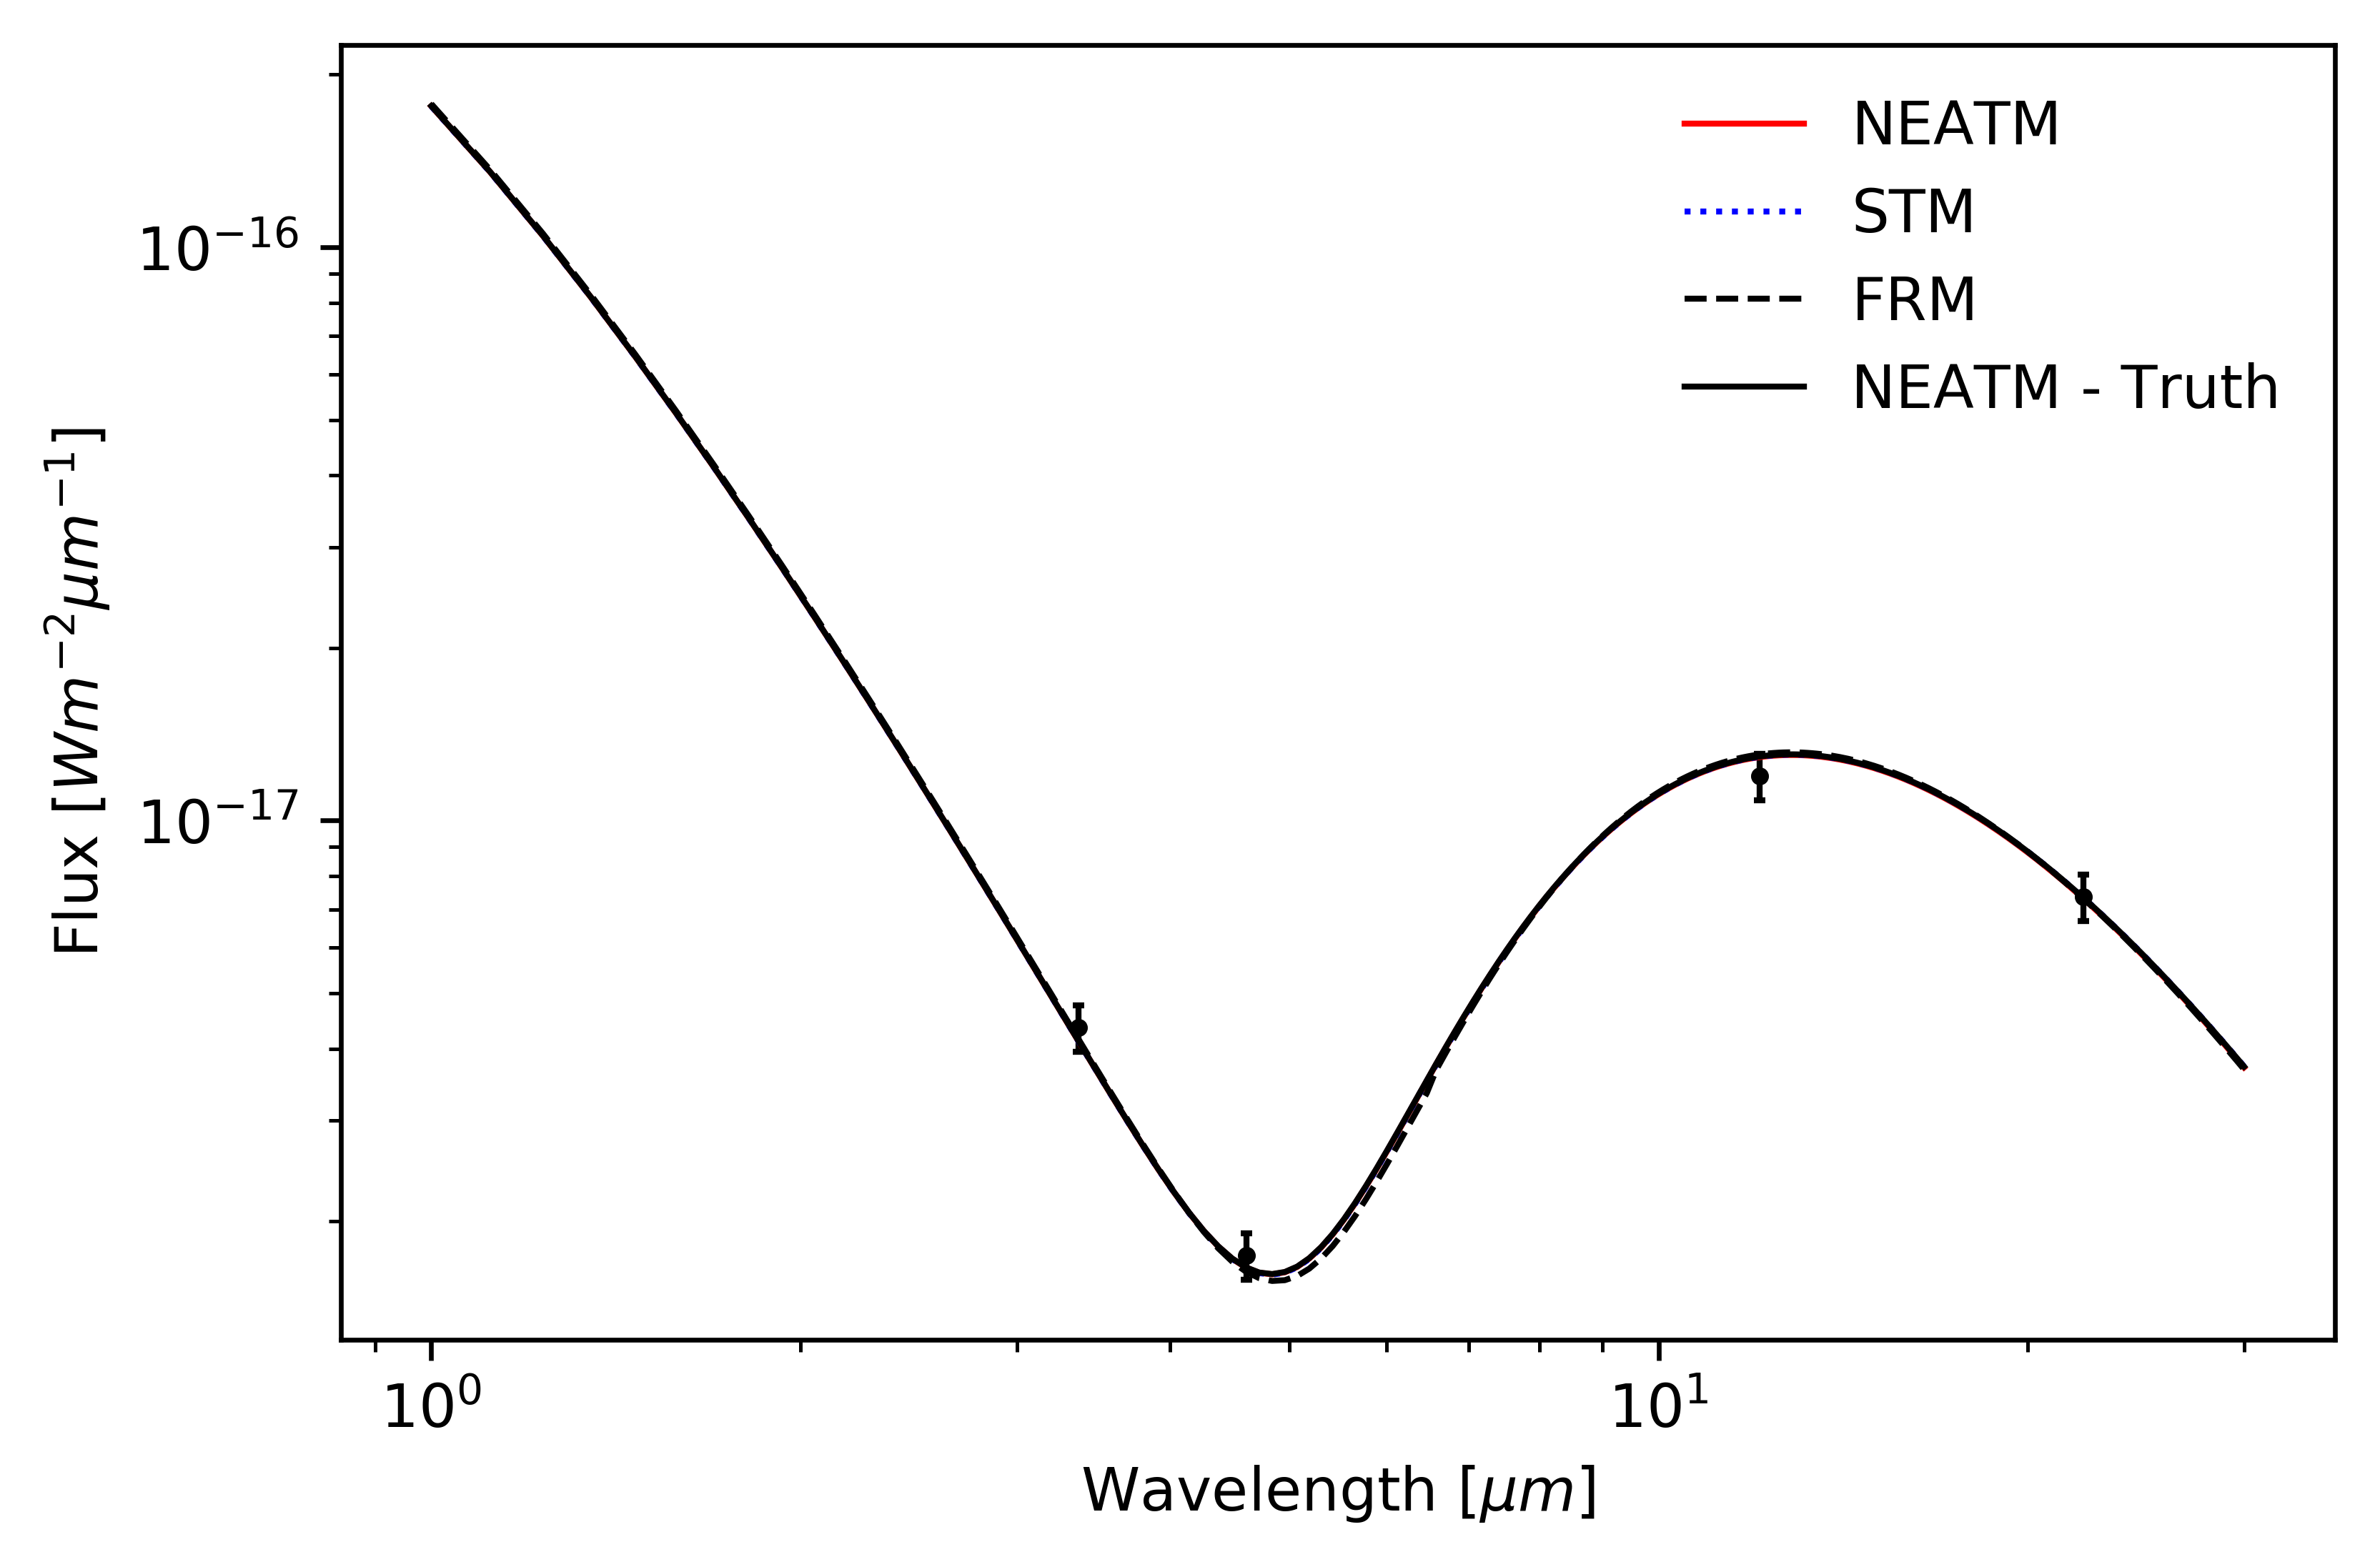

In [63]:
fig, ax = plt.subplots(1, 1, dpi=DPI)
plotSED(SED_neatm_fit, 
        ax=ax, 
        plotKwargs={"label": "NEATM", 
                    "c": "r", 
                    "lw": 1})
plotSED(SED_stm_fit, 
        ax=ax, 
        plotKwargs={"label": "STM", 
                    "c": "b", 
                    "ls": ":", 
                    "lw": 1})
plotSED(SED_frm_fit, 
        ax=ax, 
        plotKwargs={"label": "FRM", 
                    "c": "k", 
                    "ls": "--", 
                    "lw": 1})
plotSED(SED_neatm, 
        ax=ax, 
        plotKwargs={"label":"NEATM - Truth", 
                    "c" : "k" , 
                    "lw": 1})
plotObservations(obs, data, 
                 ax=ax, 
                 plotMedian=True, 
                 columnMapping=columnMapping)
ax.legend(frameon=False)
if SAVE_FIGS is True:
    fig.savefig(os.path.join(SAVE_DIR, "validation_synthetic_25obs_3param_SEDs".format(FORMAT)), 
                bbox_inches='tight',
                dpi=DPI)